In [1]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [111]:
np.linspace(0,270,10)

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270.])

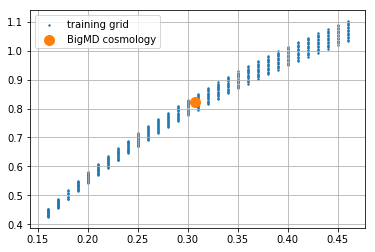

In [2]:
def load_testfile(testfile):
    nowf = open(testfile, 'r')
    bigmd_dict = {}
    grid_dict = {}
    while True:
        nowstrs = nowf.readline().split()
        #print (nowstrs)
        if nowstrs == []: break
        values = [float(nowstr) for nowstr in nowstrs[1:]]
        #cosmos = [[values[2*row],values[2*row+1] for row in range(len(values)/2)]
        if 'BigMD' in nowstrs[0]:
            bigmd_dict[nowstrs[0]] = array([[values[2*row],values[2*row+1]] for row in range(int(len(values)/2))])
        else:
            grid_dict[nowstrs[0]] = array([[values[2*row],values[2*row+1]] for row in range(int(len(values)/2))])
    return bigmd_dict, grid_dict

def mean_erbar_str(A, fmt='%.4f'):
    A0, A1 = mean(A), np.sqrt(A.var())
    return '$'+fmt%A0+'\\pm'+fmt%A1+'$'

def plot_bigmd_dict(bigmd_dict, title=None, do_plot = True):
    om_dft, sig8_dft = 0.307115, 0.8228
    keys = list(bigmd_dict.keys())
    if do_plot:
        fig, ax = subplots(figsize=(10,6))
        ax.scatter([om_dft], [sig8_dft], s=50, marker='*', c='r', 
            label='\ntest_input: \n  ('+str(om_dft)+', '+str(sig8_dft)+')')
    om_sig8s = np.ones((len(keys),2)); ikey = 0
    for key in keys:
        A = bigmd_dict[key]; om_sig8s[ikey,0] = A[:,0].mean(); om_sig8s[ikey,1] = A[:,1].mean(); ikey+=1
        if ikey==1 and do_plot: 
            ax.scatter(A[:,0],A[:,1], c='r', s=5, 
                label='\n\nsubcube_outputs_cosmology1: \n   $\\Omega_m$='+mean_erbar_str(A[:,0])+\
                       '  \n   $\\sigma_8$='+mean_erbar_str(A[:,1]))
    if do_plot:
        ax.scatter(om_sig8s[:,0], om_sig8s[:,1], c='b', s=5, 
                label='\n\ntest_predicts: \n   $\\Omega_m$='+mean_erbar_str(om_sig8s[:,0])+\
                   '  \n   $\\sigma_8$='+mean_erbar_str(om_sig8s[:,1]))
        if title != None: ax.set_title(title,fontsize=14)
        ax.grid(); ax.set_xlabel(r'$\Omega_m$', fontsize=16); 
        ax.set_ylabel(r'$\sigma_8$', fontsize=16); 
        ax.legend(loc='best')
        ax.set_xlim(0.22, 0.35); ax.set_ylim(0.66, 0.88)
    return mean(om_sig8s[:,0]), np.sqrt(om_sig8s[:,0].var()),\
        mean(om_sig8s[:,1]), np.sqrt(om_sig8s[:,1].var())

test_grid = np.loadtxt('/media/xiaodongli/0B9ADFB4341AD2BD/om_As.cosmologies')
oms, sig8s = test_grid[:,0], test_grid[:,2]
fig, ax = subplots()
ax.scatter(oms, sig8s, s= 2, label='training grid')

ax.scatter([0.307115],[0.8228],s=100, label='BigMD cosmology')
ax.legend()
ax.grid()

def values_from_filename(filename):
    for row in range(len(filename)):
        if filename[row:row+2] == 'om':
            if filename[row+2] not in ['0', '1', '-', ]:
                continue
            else:
                om = float(filename[row+2:row+7])
        elif filename[row:row+2] == 'As':
            if filename[row+2] == '_':
                continue
            else:
                As = float(filename[row+2:row+7])
        elif filename[row:row+3] == 'sig':
            sig8 = float(filename[row+7:row+13])
    return om, As, sig8

def plot_grid_dict(grid_dict, title=None, do_plot = True, polyfit_deg = 8):
    oms, Ass, sig8s, rlts, avg_rlts, doms, dsig8s = [], [], [], [], [], [], []; ikey=0
    if do_plot:
        fig, axs = subplots(1, 3, figsize=(16,5), )
        ax1, ax2, ax3 = axs
    for key in grid_dict.keys():
        om, As, sig8 = values_from_filename(key)
        oms.append(om); Ass.append(As); sig8s.append(sig8)
        rlts.append( np.copy(grid_dict[key]) )
        ommean, sig8mean = grid_dict[key][:,0].mean(), grid_dict[key][:,1].mean()
        avg_rlts.append([ommean, sig8mean])
        doms.append(ommean-om); dsig8s.append(sig8mean-sig8)
        if do_plot and ikey%9==0:
            ax1.scatter([om], [sig8], s=10, marker='o', c='b')
            ax1.scatter([ommean], [sig8mean], s=10, marker='p', c='r')
            ax1.plot([om, ommean], [sig8, sig8mean], ls='-', lw=1, )
        ikey += 1
    if do_plot:
        if title != None: ax1.set_title(title,fontsize=14)
        ax1.set_xlabel(r'$\Omega_m$', fontsize=16); 
        ax1.set_ylabel(r'$\sigma_8$', fontsize=16); 
        ax2.set_xlabel(r'$\Omega_m$', fontsize=16); 
        ax2.set_ylabel(r'$\Delta \Omega_m$', fontsize=16); 
        ax3.set_xlabel(r'$\sigma_8$', fontsize=16); 
        ax3.set_ylabel(r'$\Delta \sigma_8$', fontsize=16); 
        ax1.set_xlim(0.1, 0.5); ax1.set_ylim(0.3, 1.2)
        ax2.scatter(oms, doms, s=3 ); ax3.scatter(sig8s, dsig8s, s=3)
        
        poly1, poly2 = np.polyfit(oms, doms, deg=polyfit_deg), \
            np.polyfit(sig8s, dsig8s, deg=polyfit_deg);
        X1, X2 = np.linspace(min(oms), max(oms), 100), \
            np.linspace(min(sig8s), max(sig8s), 100)
        ax2.plot(X1, np.polyval(poly1, X1)); ax3.plot(X2, np.polyval(poly2, X2))
        
        for ax in [ax1,ax2,ax3]:
            ax.grid(); ax.legend(loc='best')
        
        fig.tight_layout()
    return np.array(oms), np.array(sig8s), np.array(doms), np.array(dsig8s)



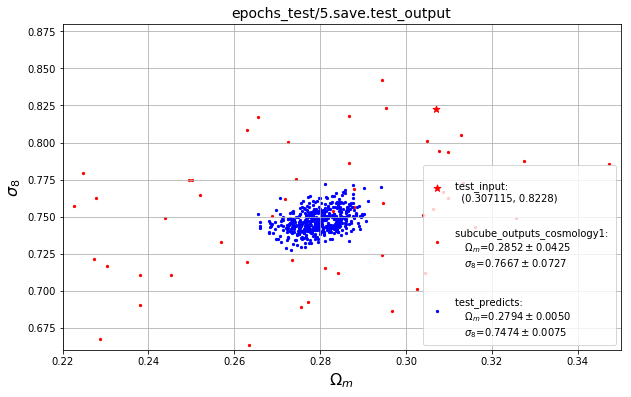

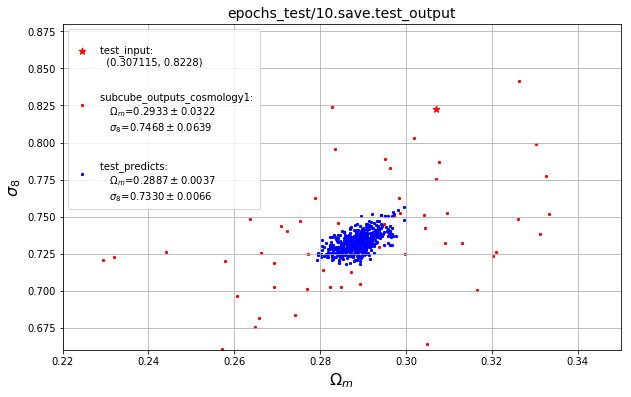

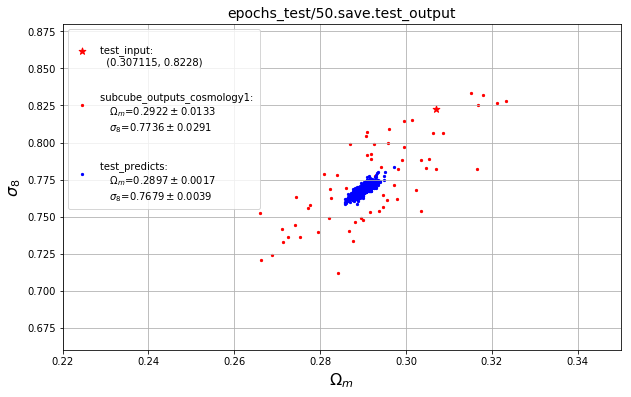

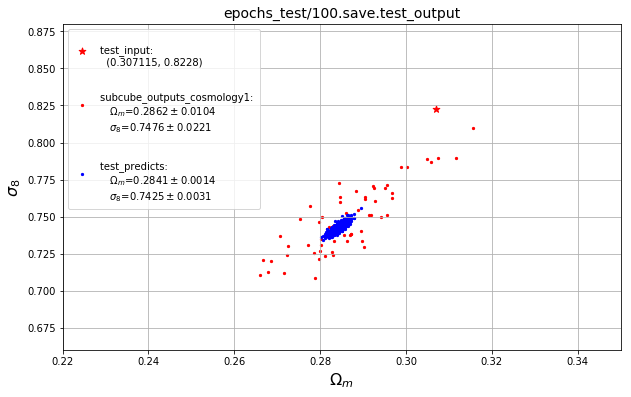

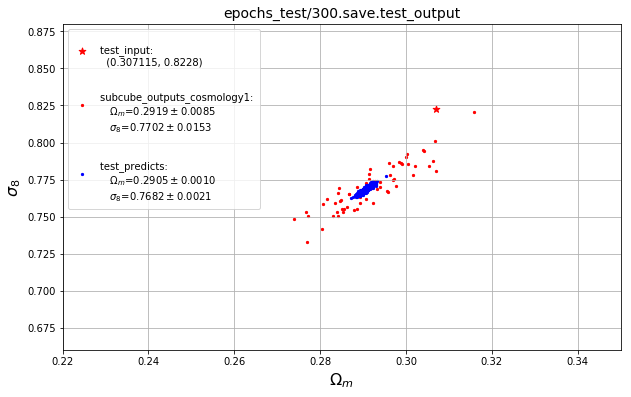

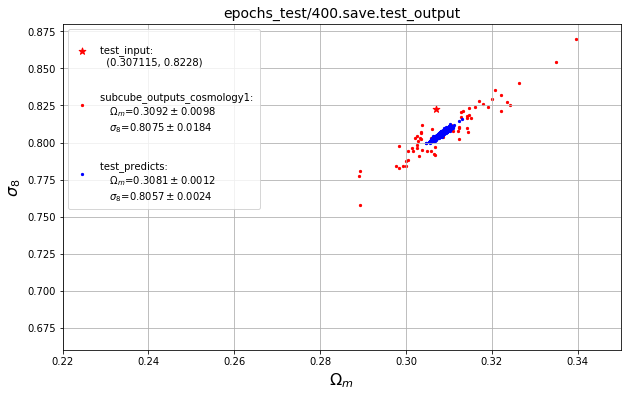

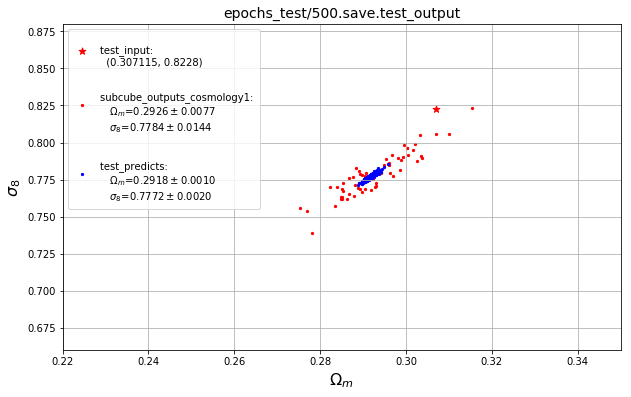

In [112]:
epochs_list = [5, 10, 50, 100, 300, 400, 500]
rlts = []
for epochs in epochs_list:
    file = 'epochs_test/'+str(epochs)+'.save.test_output'
    bigmd_dict, grid_dict = load_testfile(file)
    om, omer, sig8, sig8er = plot_bigmd_dict(bigmd_dict, title=file); plt.show()
    rlts.append([om, omer, sig8, sig8er])
    #plot_grid_dict(grid_dict, title=file)

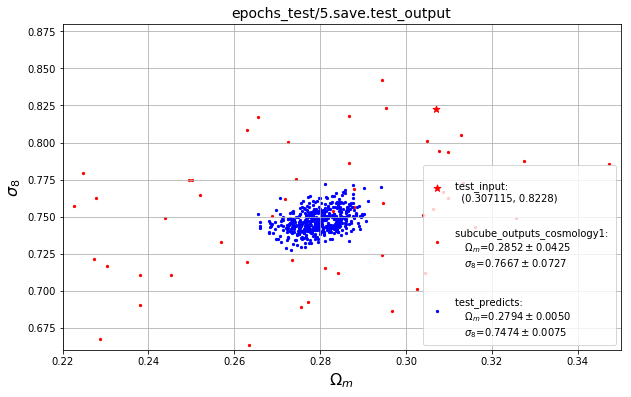

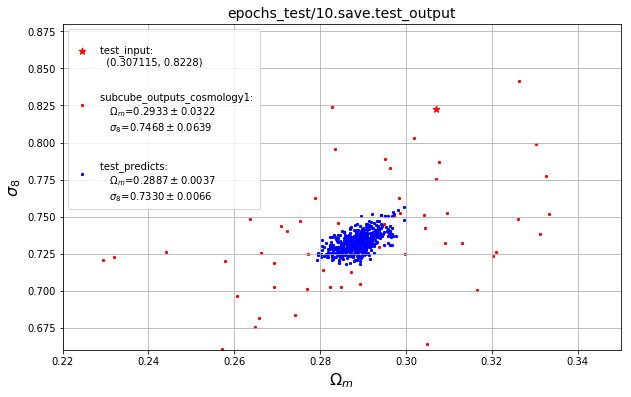

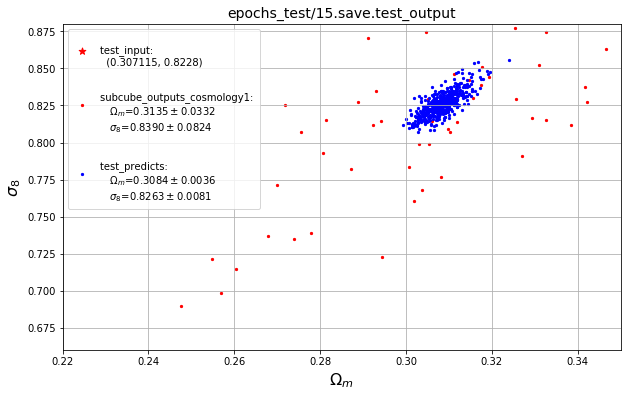

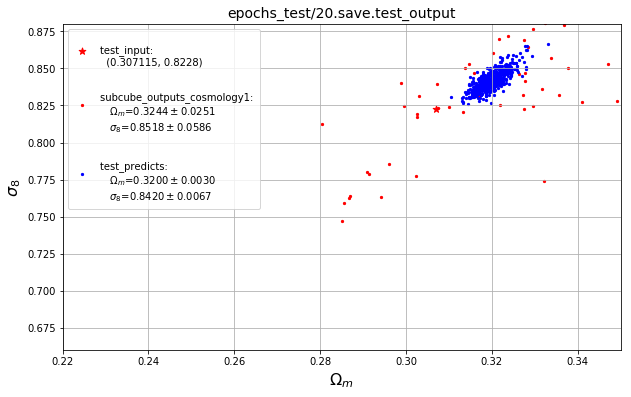

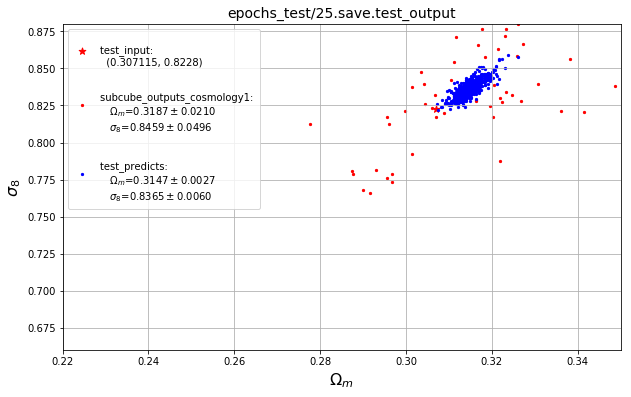

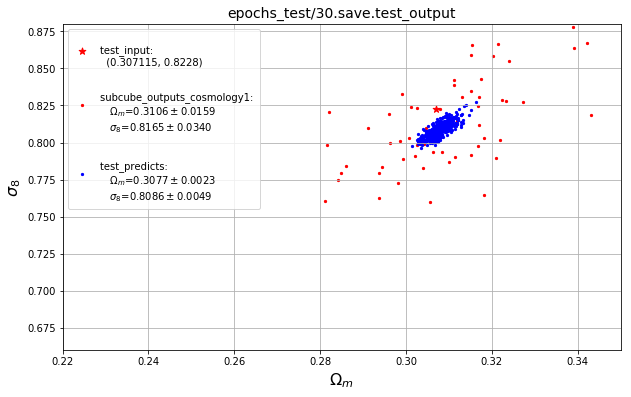

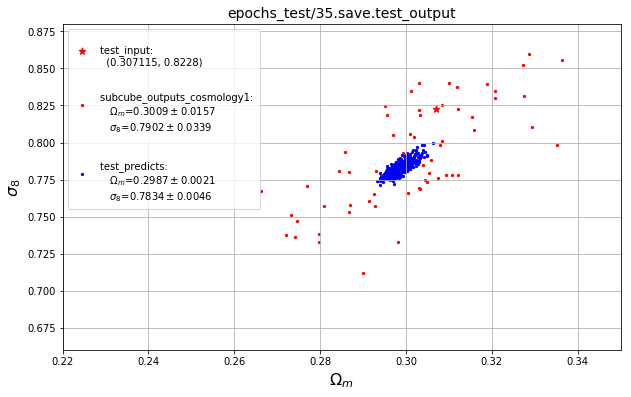

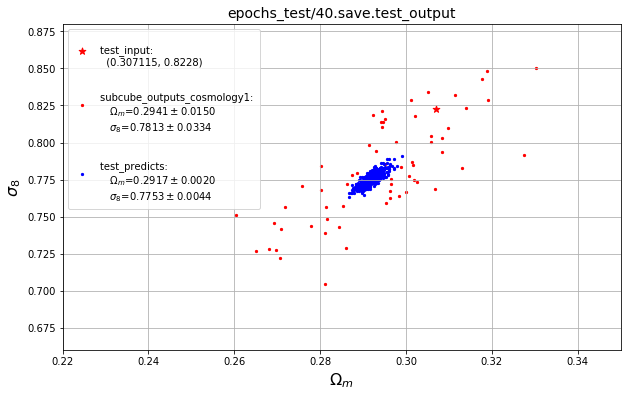

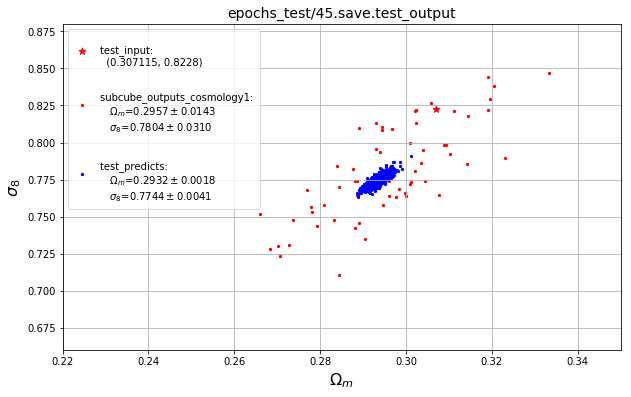

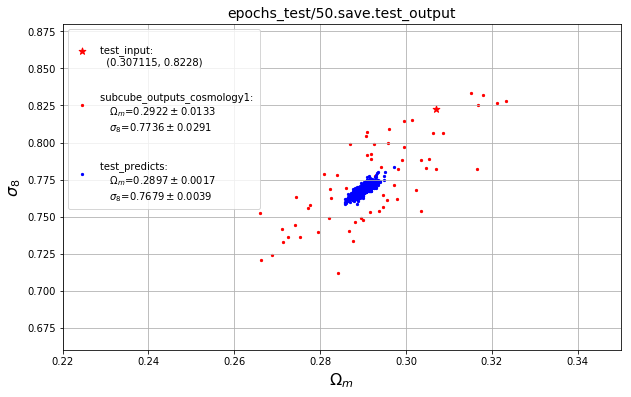

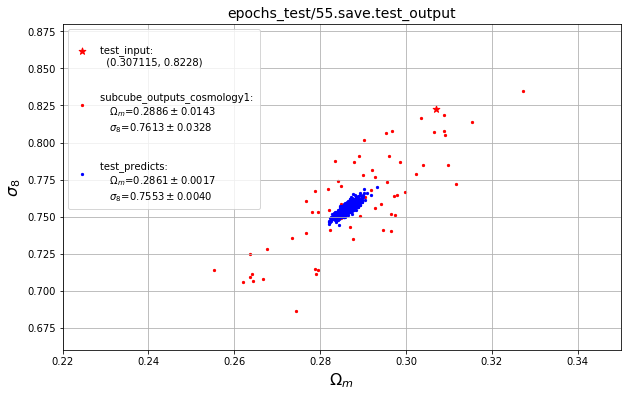

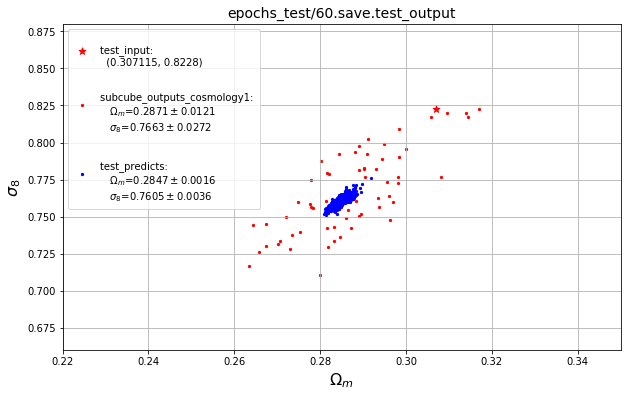

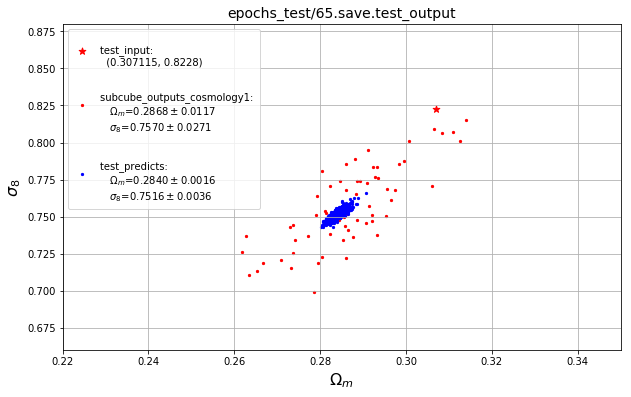

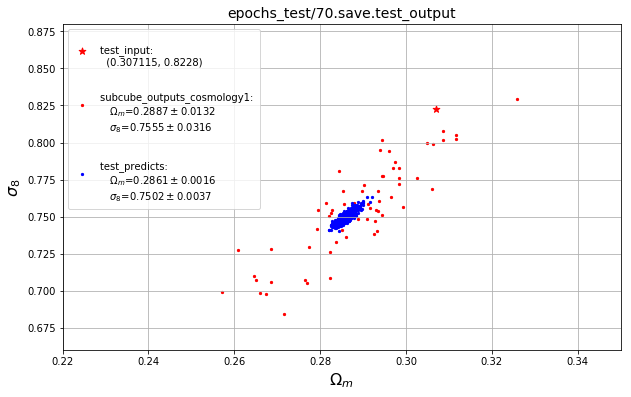

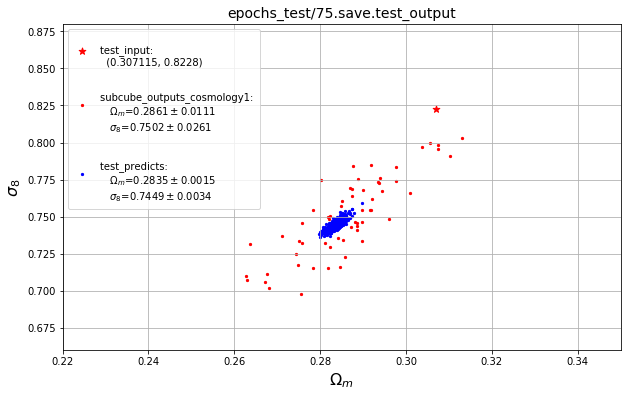

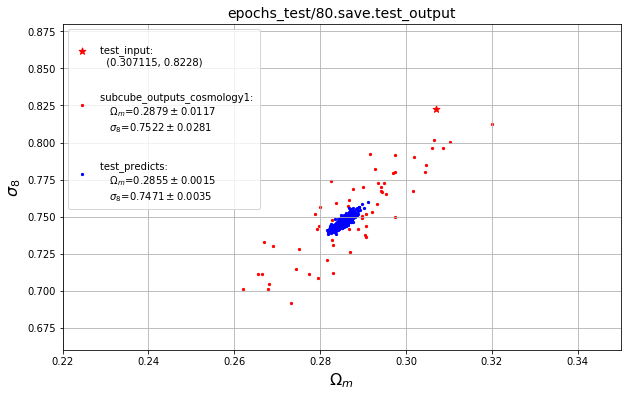

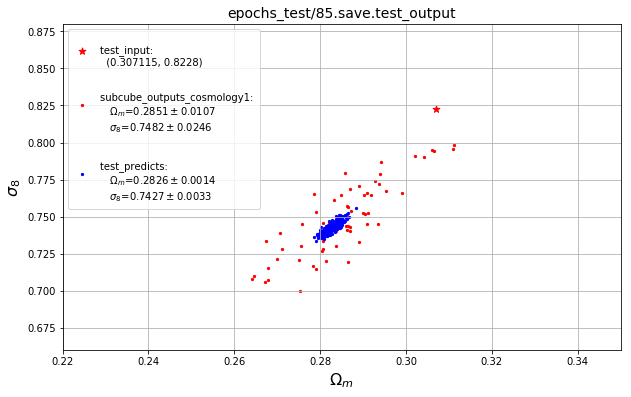

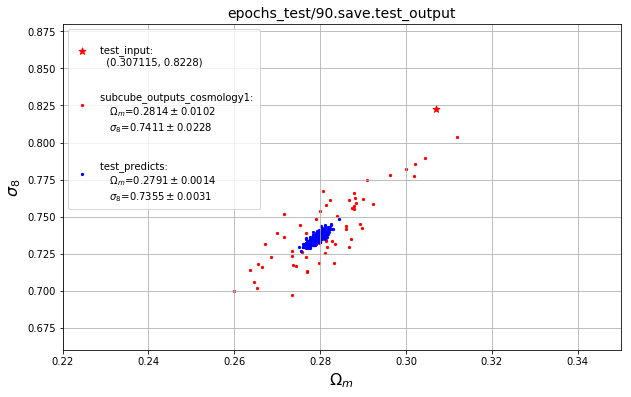

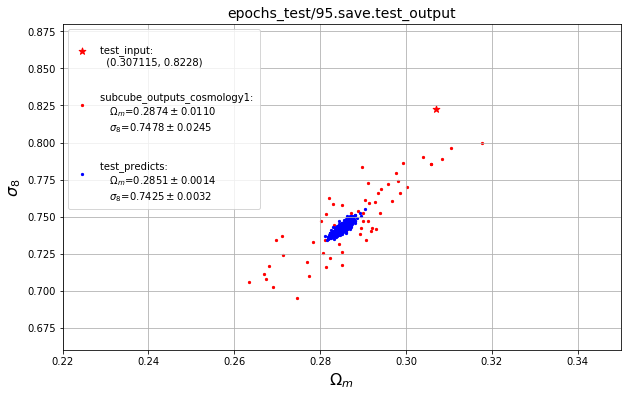

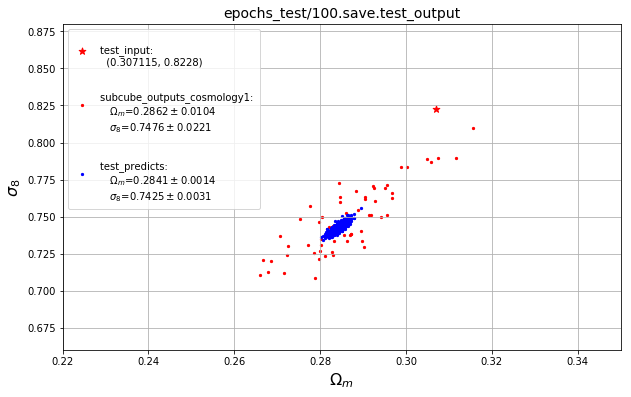

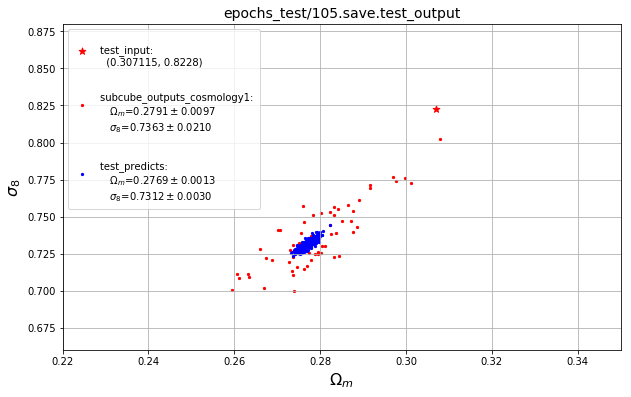

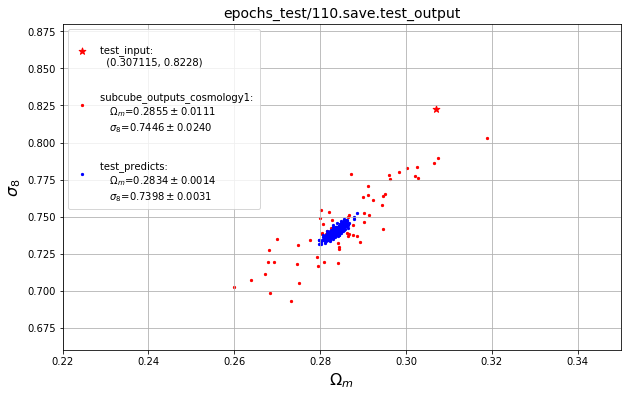

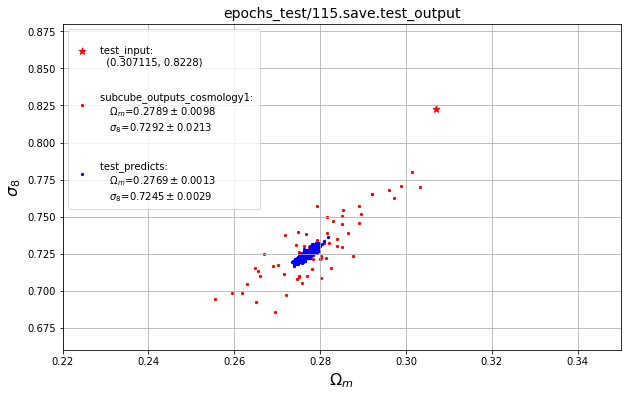

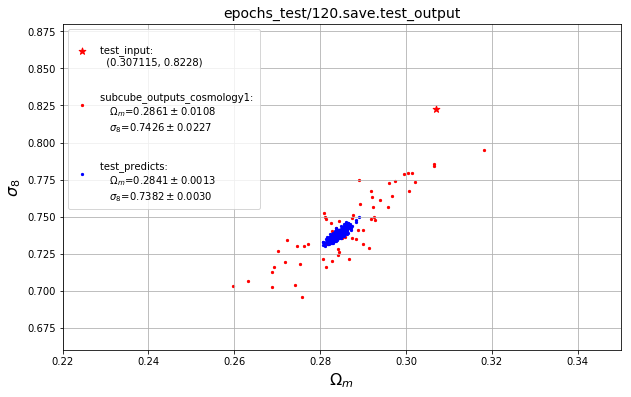

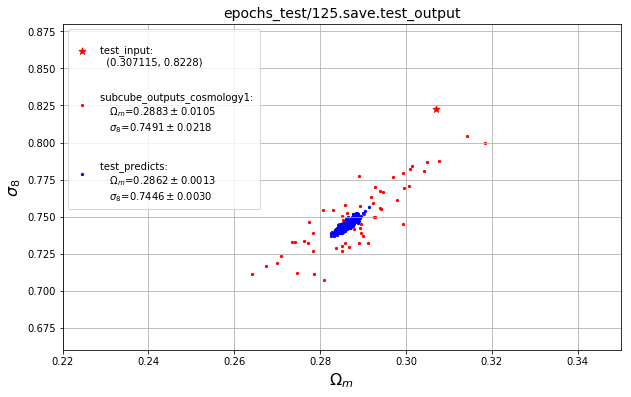

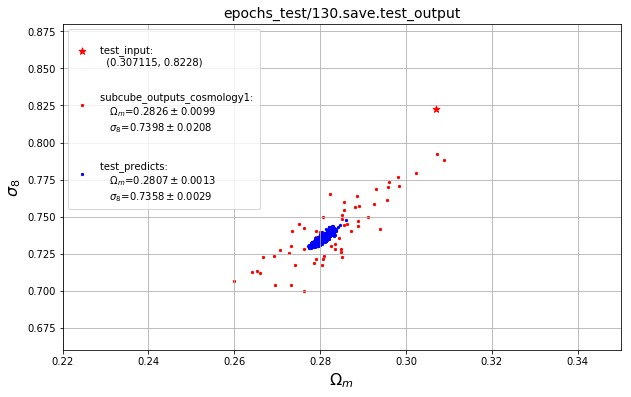

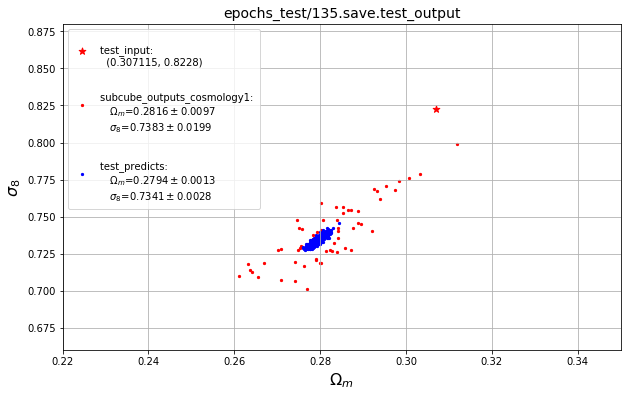

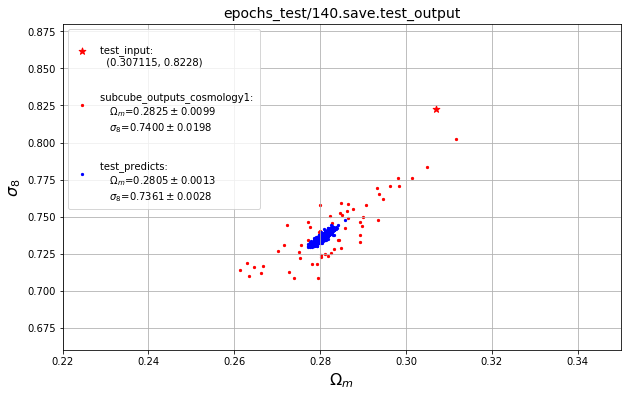

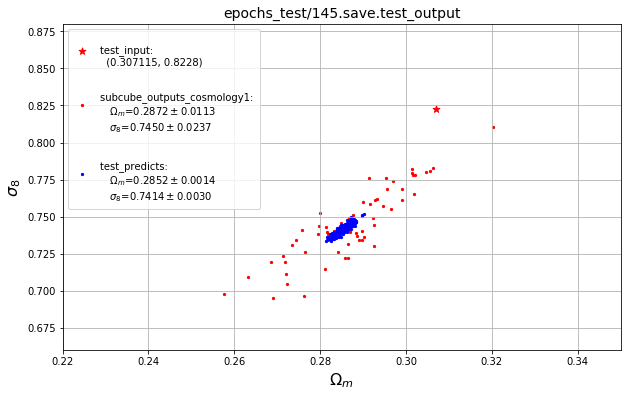

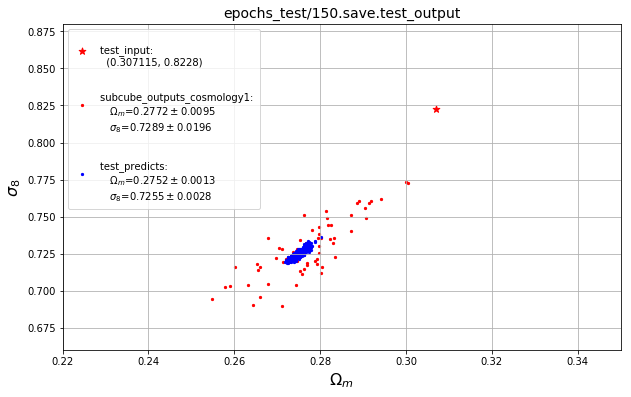

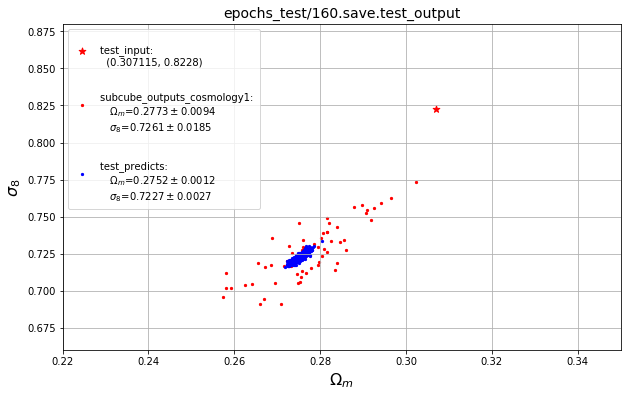

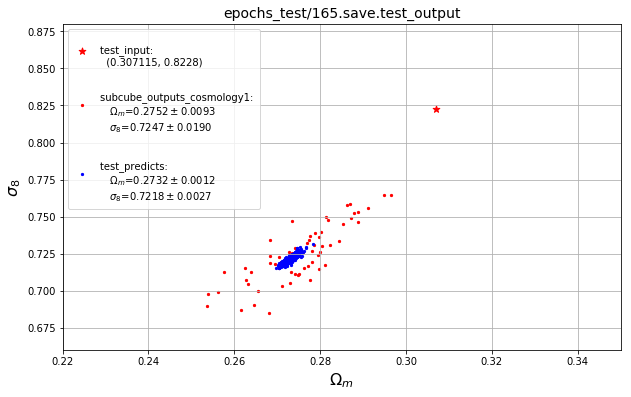

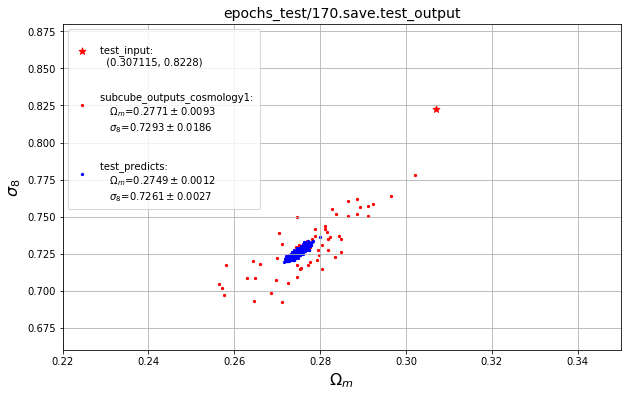

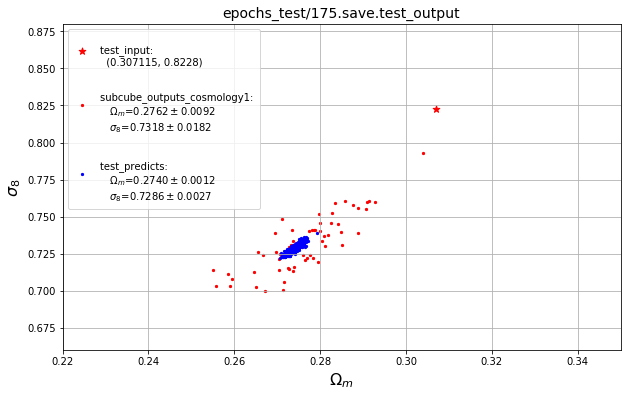

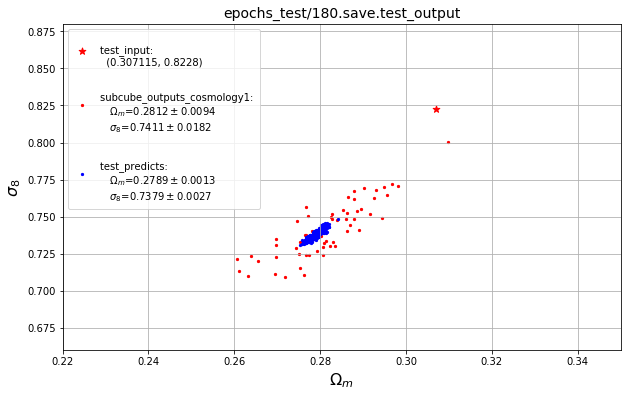

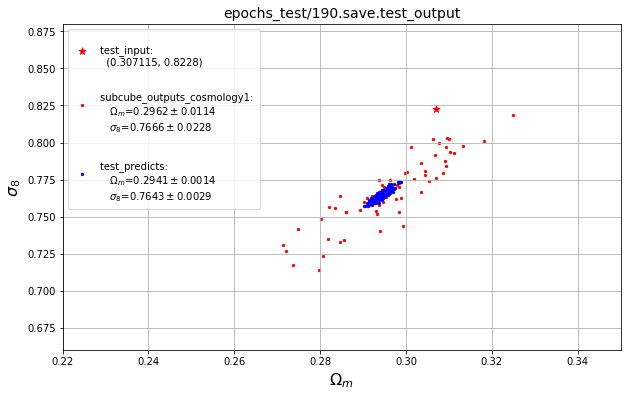

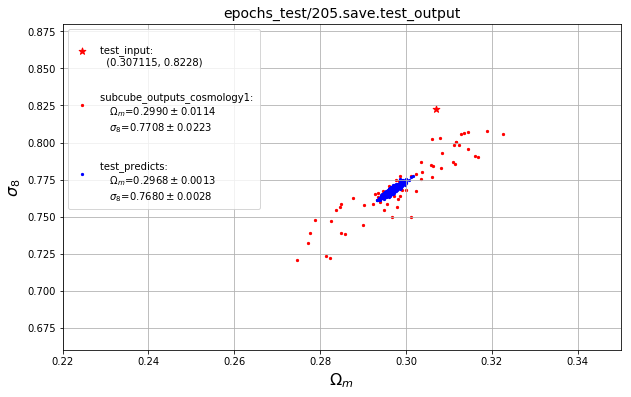

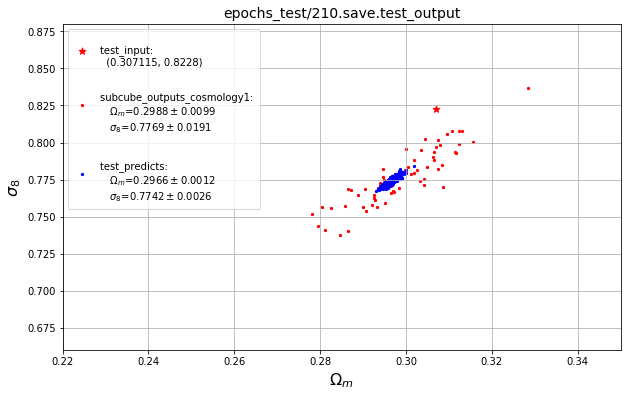

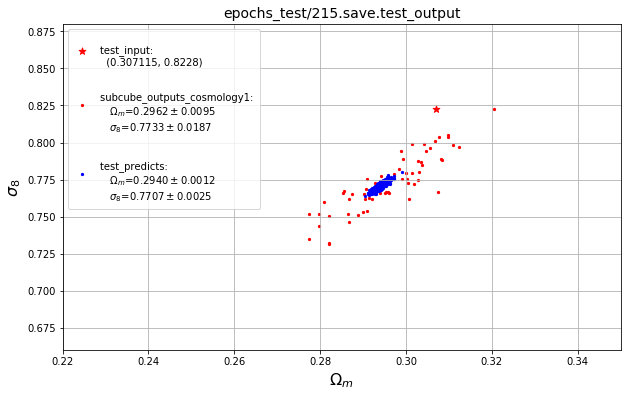

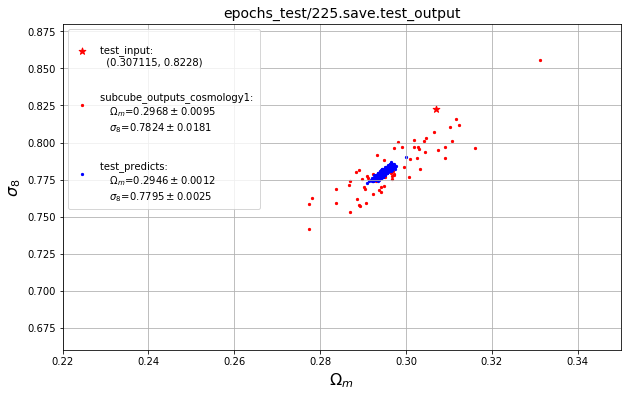

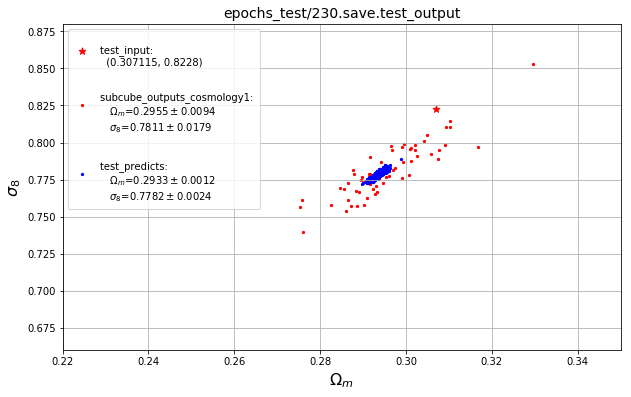

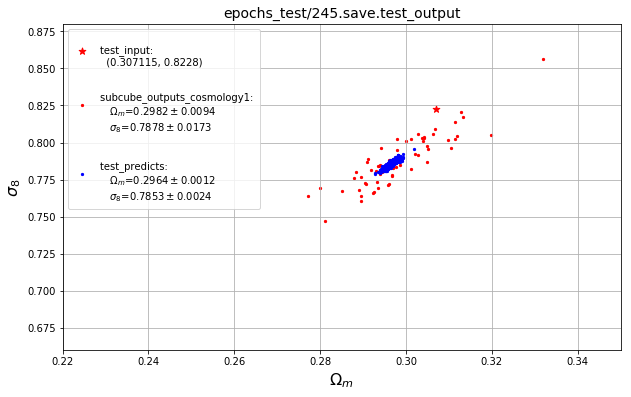

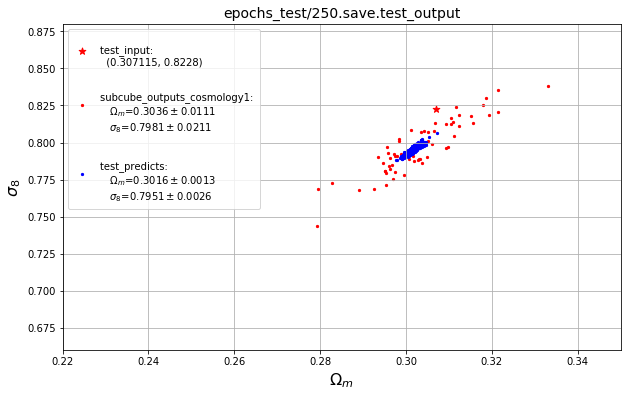

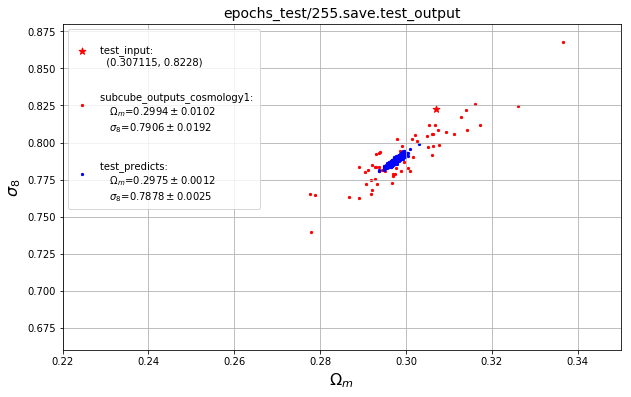

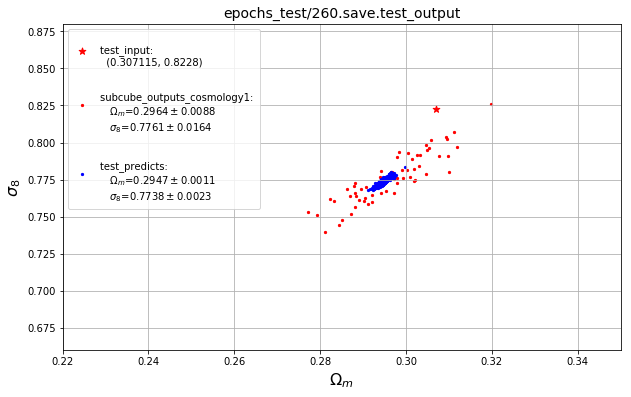

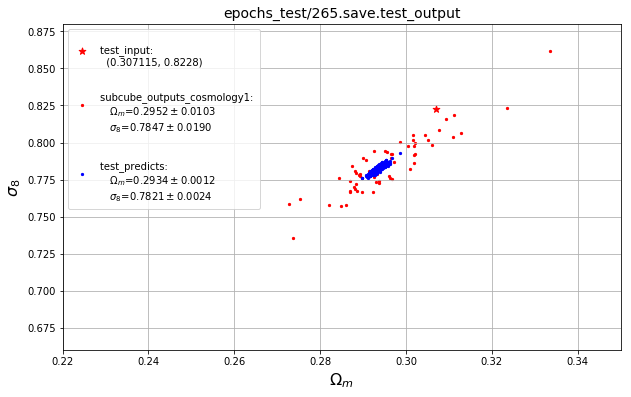

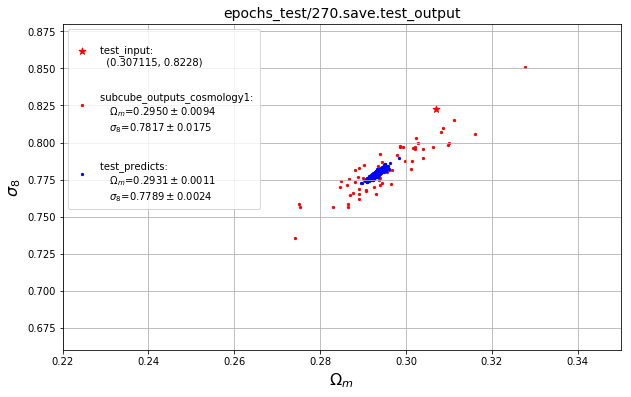

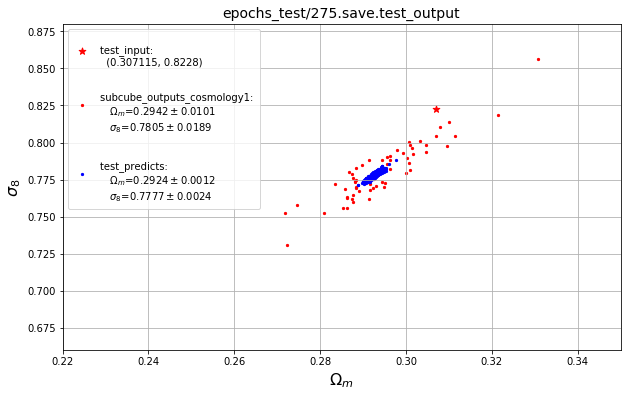

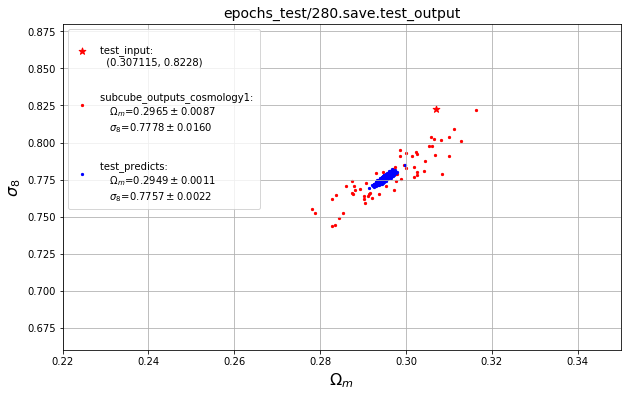

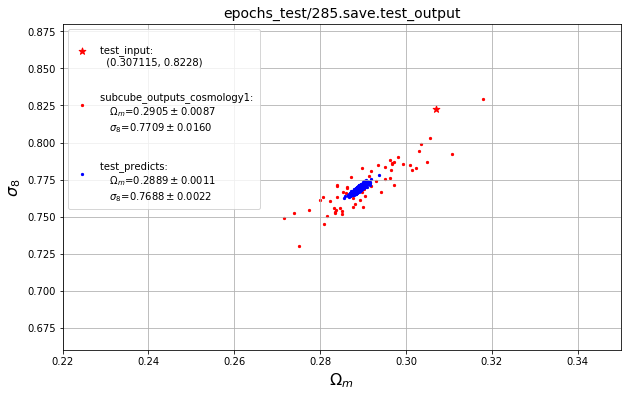

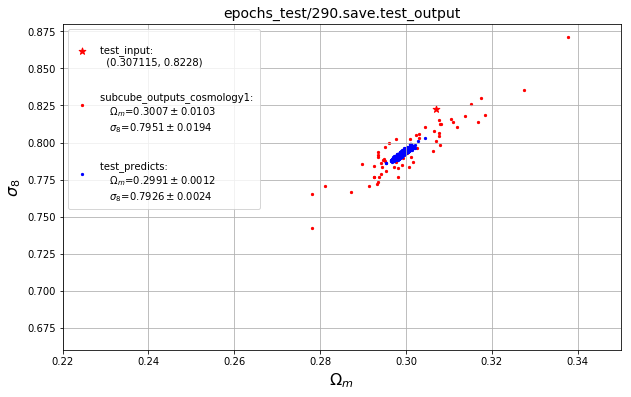

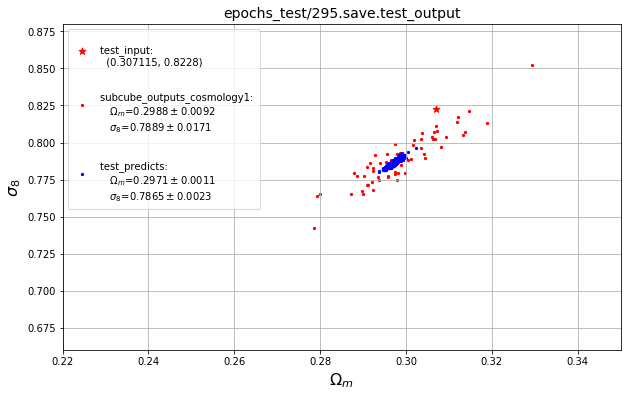

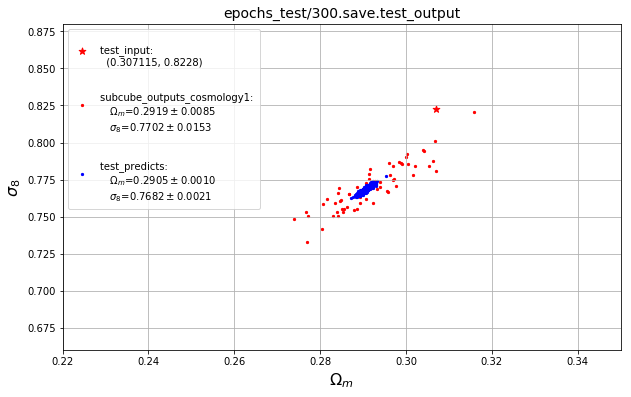

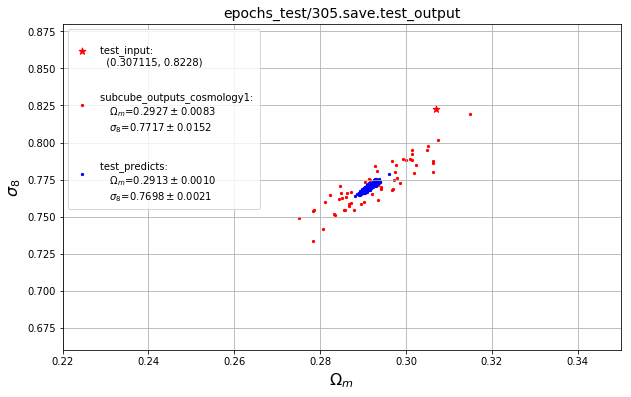

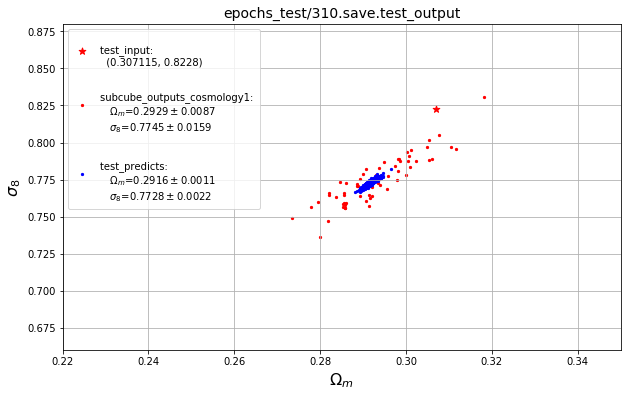

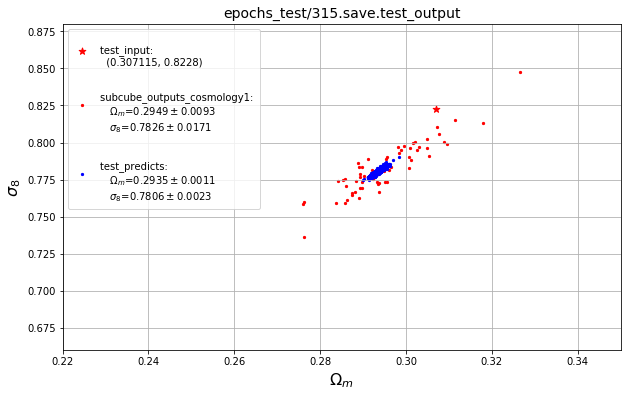

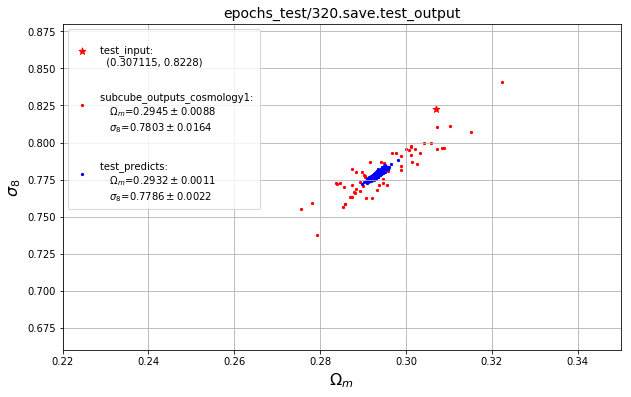

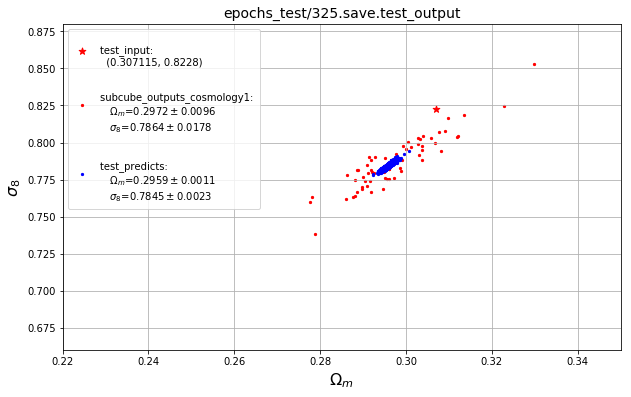

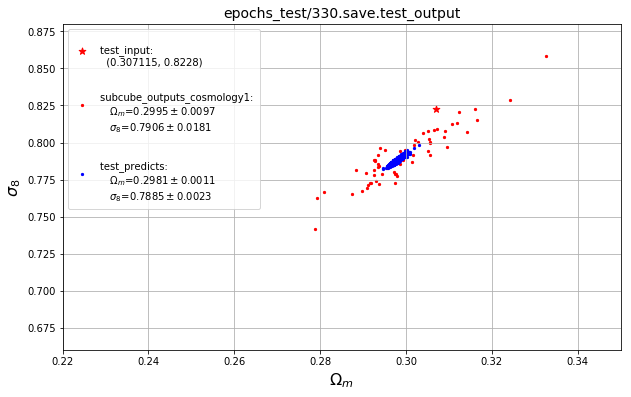

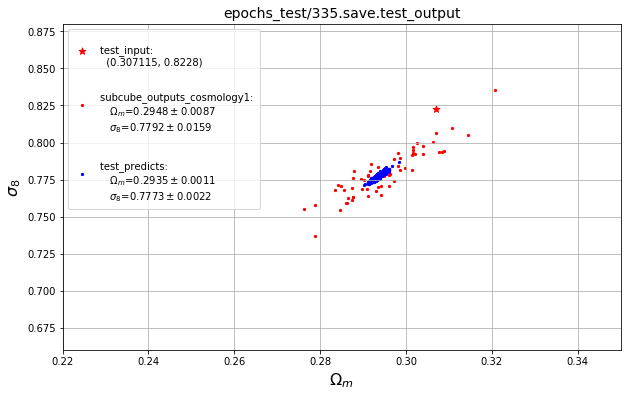

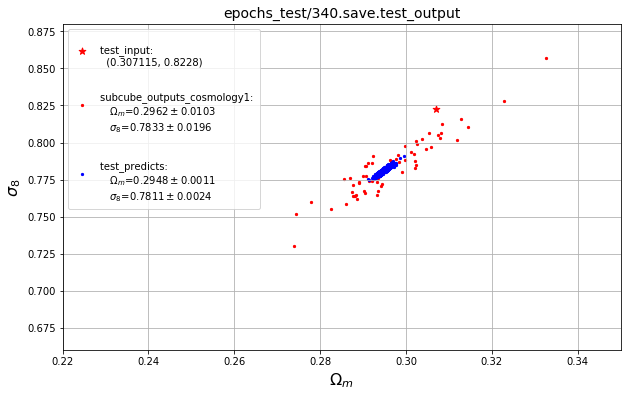

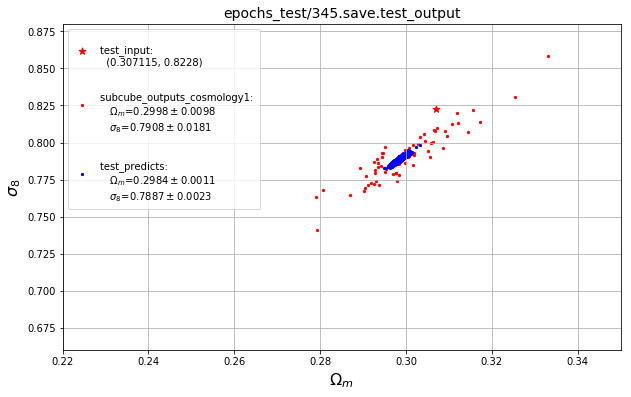

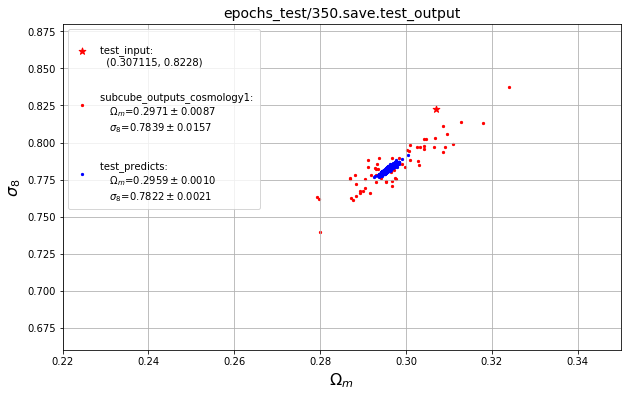

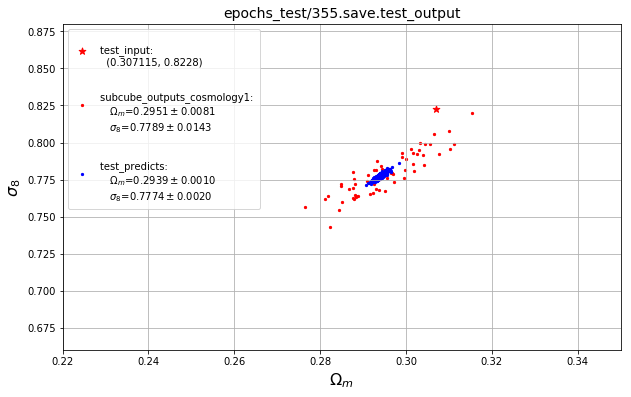

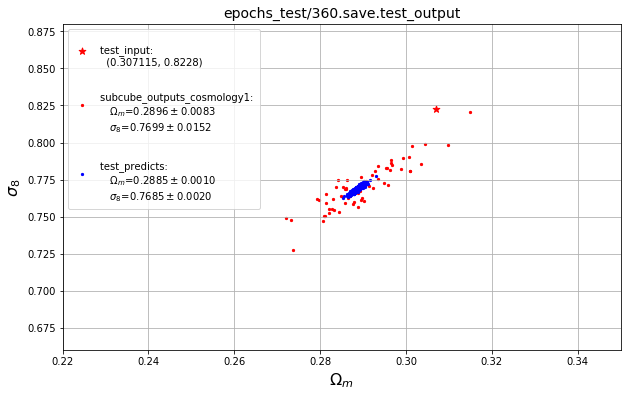

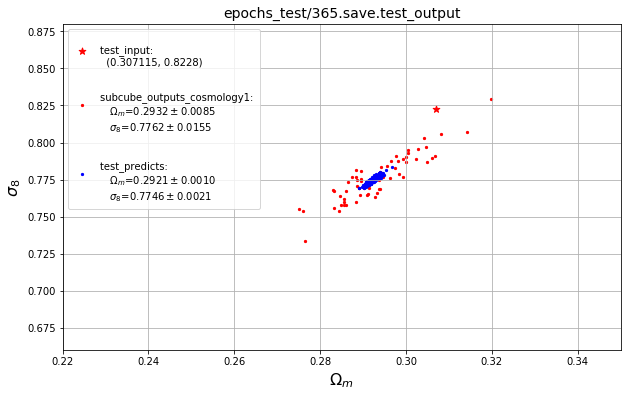

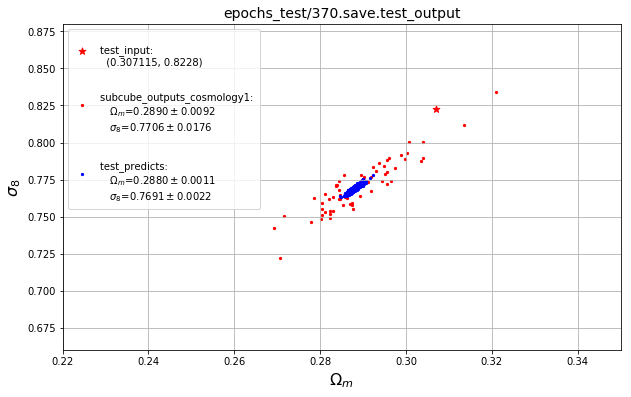

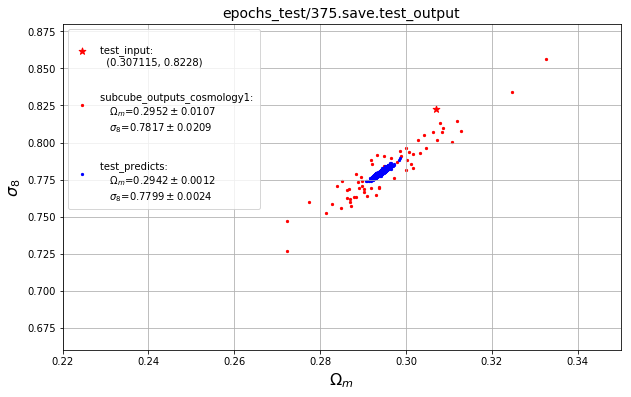

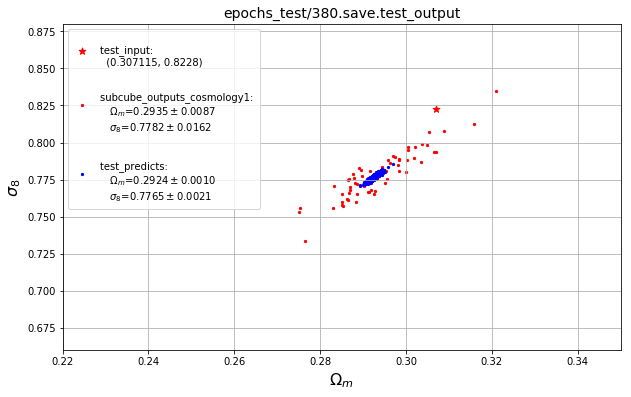

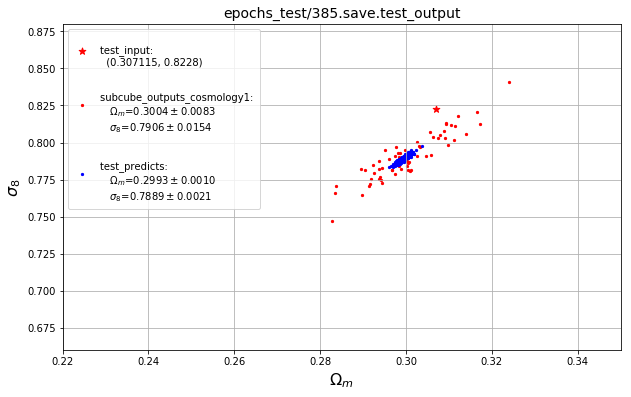

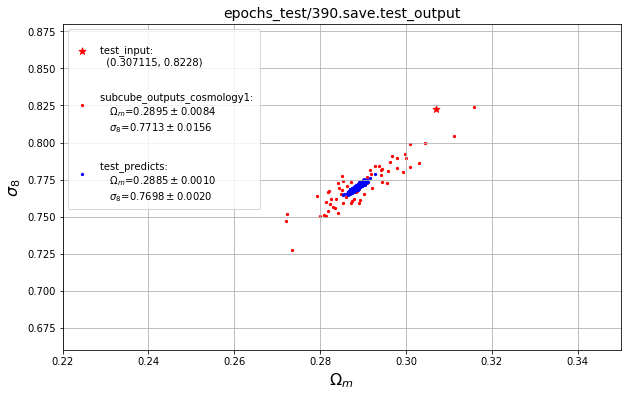

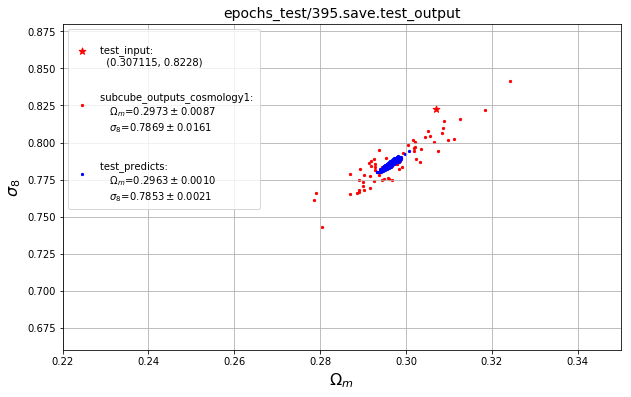

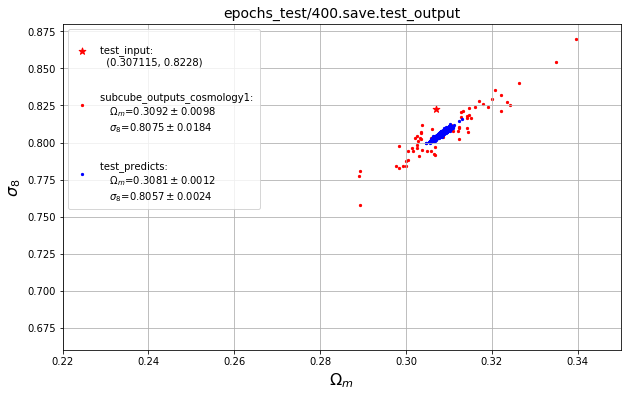

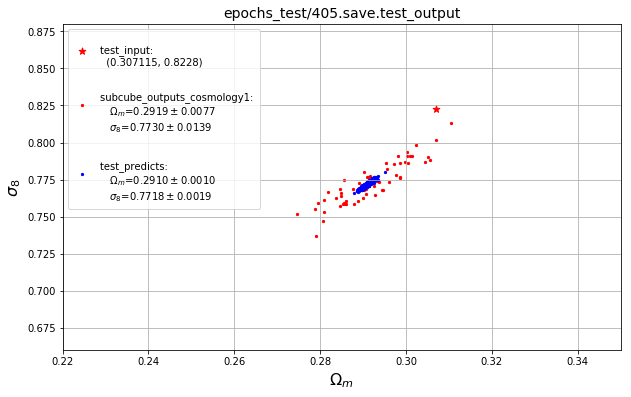

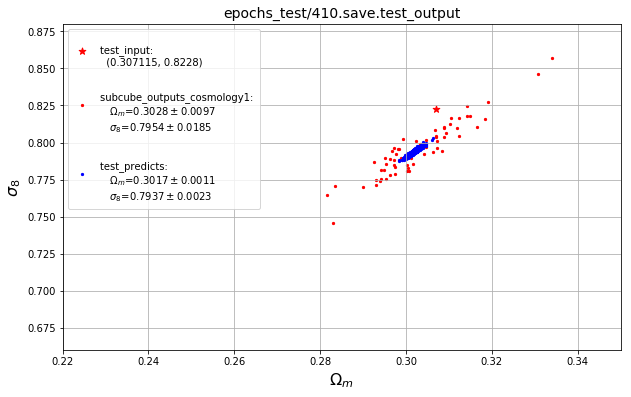

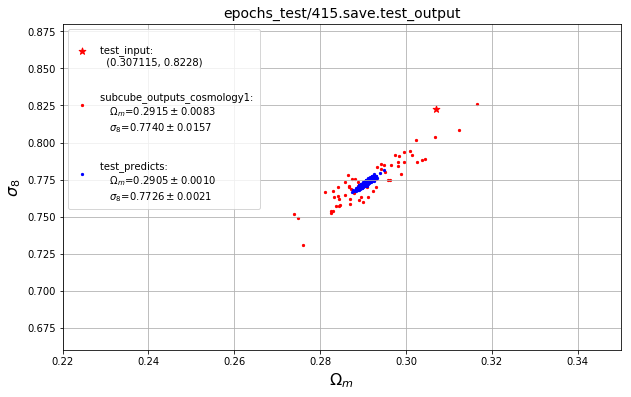

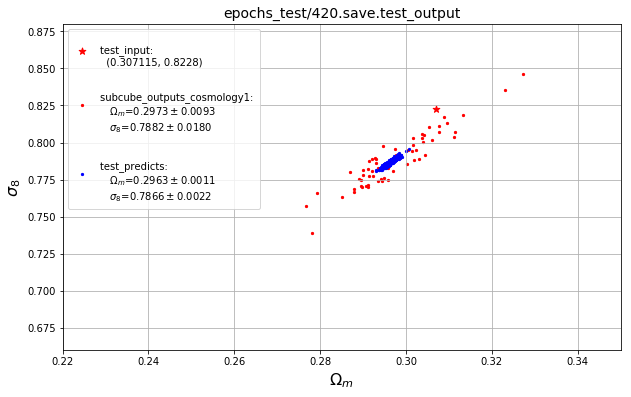

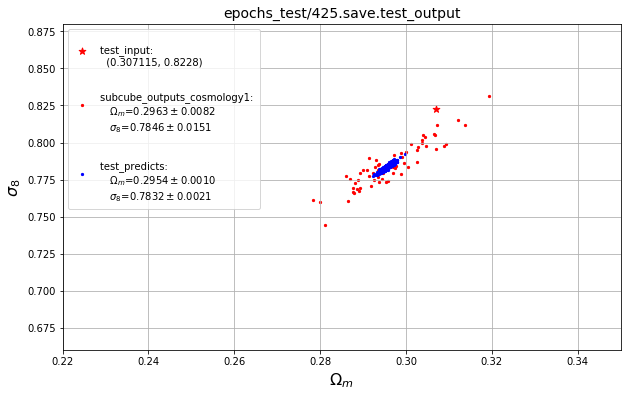

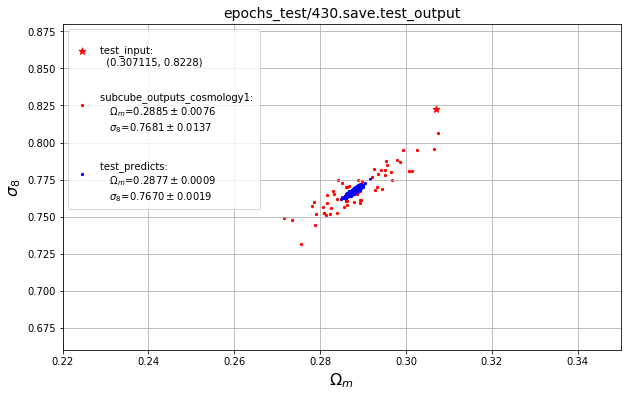

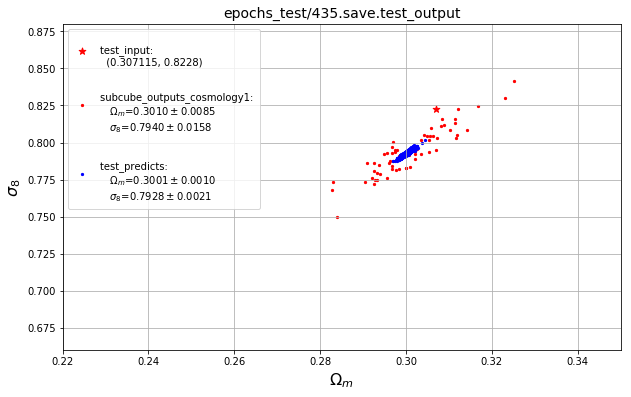

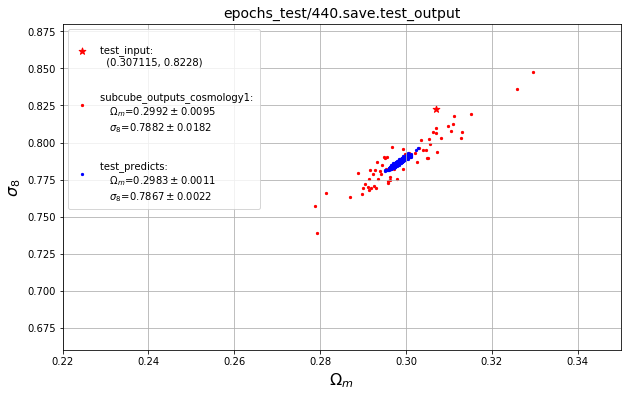

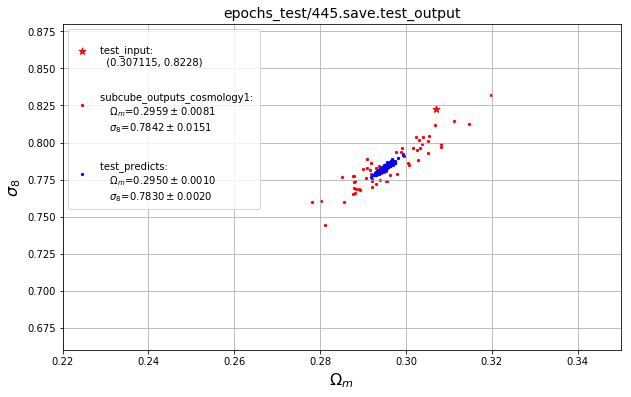

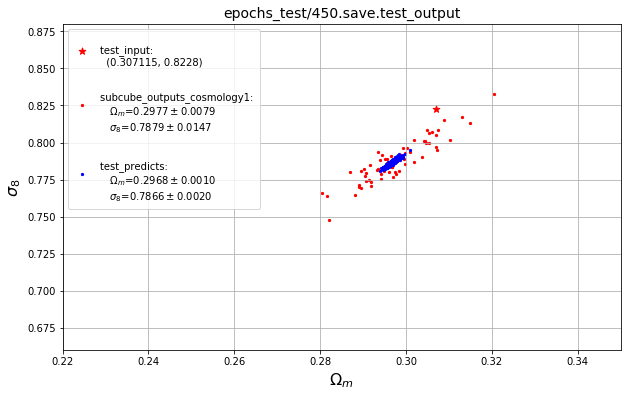

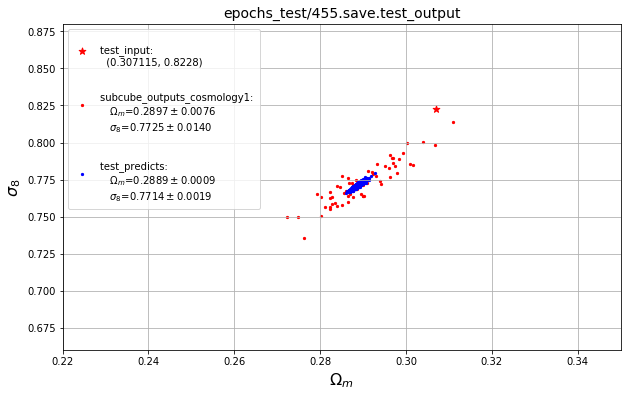

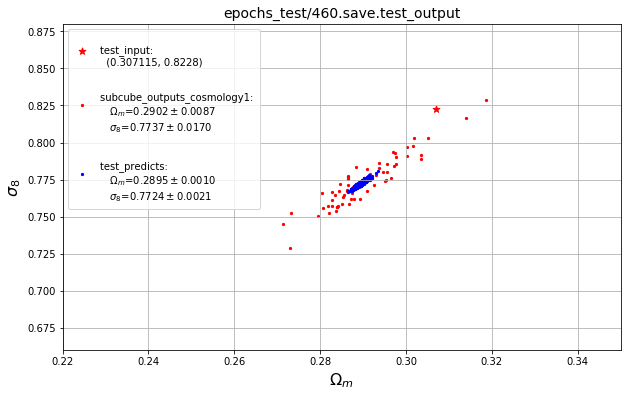

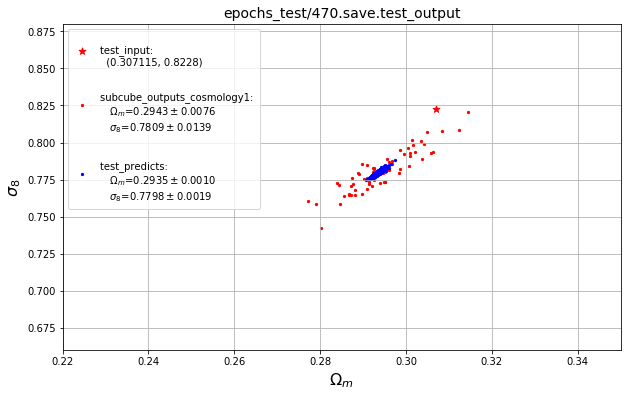

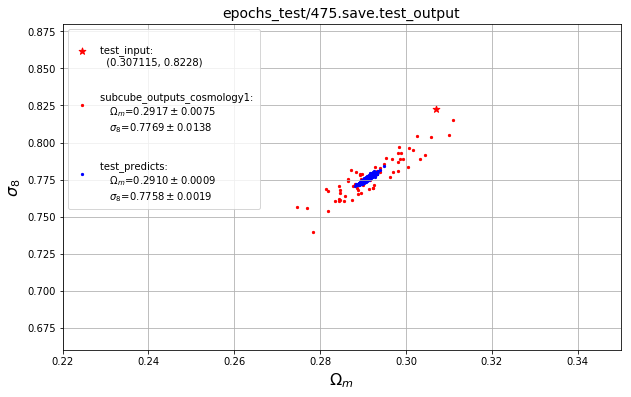

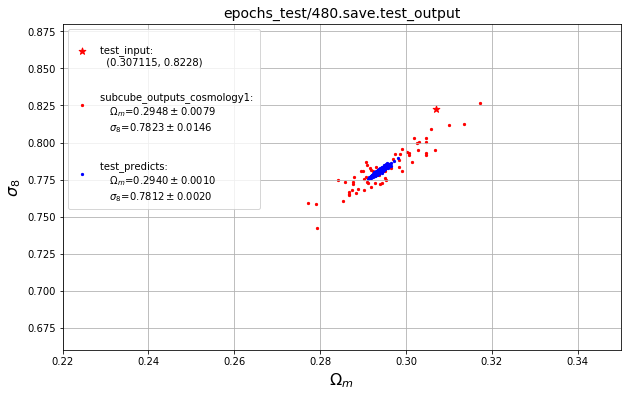

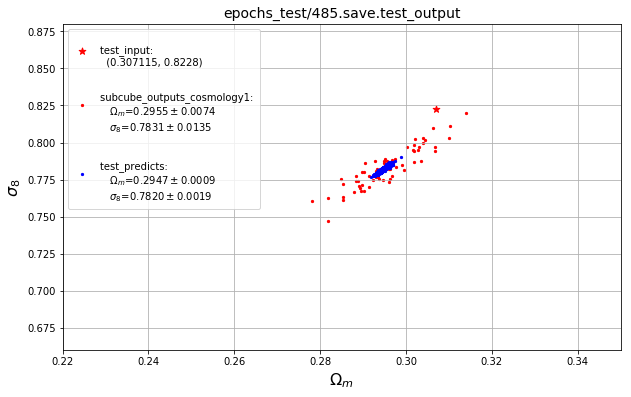

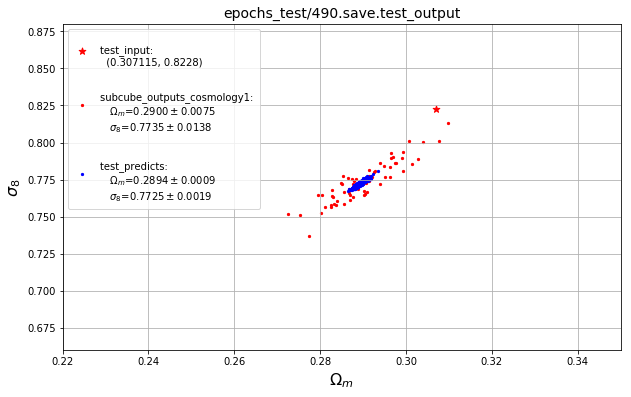

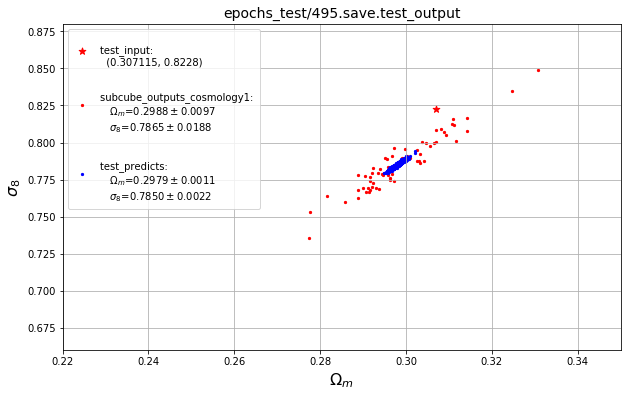

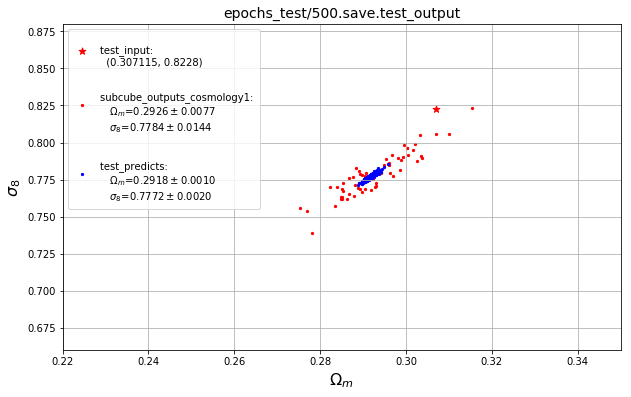

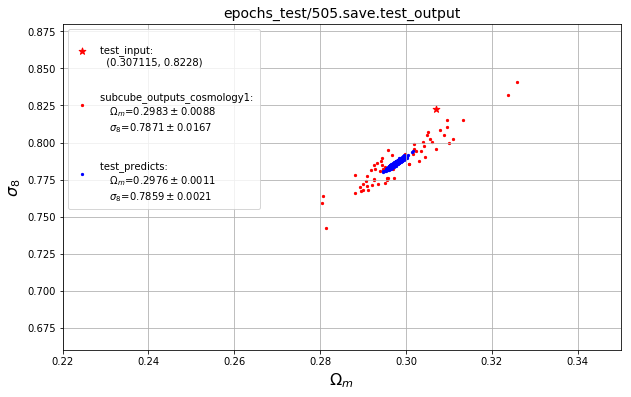

In [3]:
epochs_list = range(5,510,5)
rlts = []
for epochs in epochs_list:
    file = 'epochs_test/'+str(epochs)+'.save.test_output'
    bigmd_dict, grid_dict = load_testfile(file)
    om, omer, sig8, sig8er = plot_bigmd_dict(bigmd_dict, title=file); plt.show()
    rlts.append([om, omer, sig8, sig8er])

/home/xiaodongli/software/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


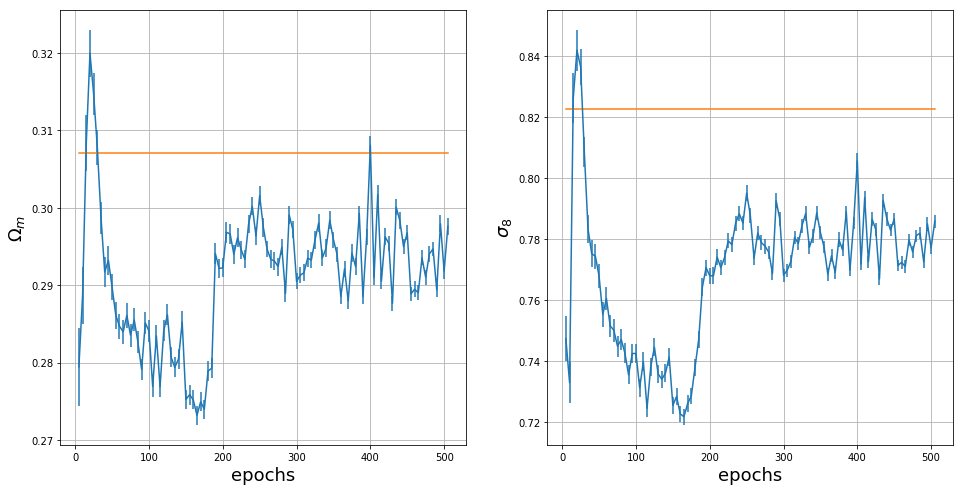

In [5]:
rlts = array(rlts)
fig, axs = subplots(1,2, figsize=(16,8)); ax1, ax2 = axs
ax1.errorbar(epochs_list, rlts[:,0], rlts[:,1])
ax1.plot(epochs_list, [0.3071 for xx in epochs_list])
ax2.errorbar(epochs_list, rlts[:,2], rlts[:,3])
ax2.plot(epochs_list, [0.8228 for xx in epochs_list])

ax1.grid();ax2.grid();
ax1.set_ylabel('$\\Omega_m$', fontsize=18)
ax2.set_ylabel('$\\sigma_8$', fontsize=18)
ax1.set_xlabel('epochs', fontsize=18); ax2.set_xlabel('epochs', fontsize=18)

fig.show()

In [116]:
def binned_erbar(y, nbin = 10):
    ys = np.split(y,nbin)
    ymeans = [yy.mean() for yy in ys]
    yers = [np.sqrt(yy.var()) for yy in ys]
    return ymeans, yers

In [136]:
def learningcurve_single(filename_function, var_list, var_name = 'epochs', curve_name = '',
                 fig =None, axs=None, ls='-'):
    rlts = []; X = []
    for var in var_list:
        try:
            bigmd_dict, grid_dict = load_testfile(filename_function(var))
            om, omer, sig8, sig8er = plot_bigmd_dict(bigmd_dict, title=filename_function(var), do_plot=False); 
            rlts.append([om, omer, sig8, sig8er]); X.append(var)
        except:
            pass
    rlts = array(rlts)
    if fig == None:
        fig, axs = subplots(1,2, figsize=(16,8))
    ax1, ax2 = axs
    ax1.errorbar(X, rlts[:,0], rlts[:,1], label=curve_name, ls=ls)
    ax1.plot(X, [0.3071 for xx in X], lw=2, c='k')
    ax2.errorbar(X, rlts[:,2], rlts[:,3], label=curve_name, ls=ls)
    ax2.plot(X, [0.8228 for xx in X], lw=2, c='k')

    ax1.grid(b=True);ax2.grid(b=True);
    ax1.set_ylabel('$\\Omega_m$', fontsize=18)
    ax2.set_ylabel('$\\sigma_8$', fontsize=18)
    ax1.set_xlabel(var_name, fontsize=18); ax2.set_xlabel(var_name, fontsize=18)
    #ax1.legend(fontsize=16)
    fig.show()
    return fig, axs, X, rlts

def learningcurve_grid(filename_function, var_list, var_name = 'epochs', curve_name = '',
                 fig =None, axs=None, ls='-'):
    rlts = []; X = []
    for var in var_list:
        try:
            bigmd_dict, grid_dict = load_testfile(filename_function(var))
            oms, sig8s, doms, dsig8s = plot_grid_dict(grid_dict,  do_plot=False)
            #print(oms, sig8s, doms, dsig8s)
            rlts.append([doms.mean(), np.sqrt(doms.var()), dsig8s.mean(), np.sqrt(dsig8s.var())]); 
            X.append(var)
        except:
            pass
    rlts = array(rlts)
    if fig == None:
        fig, axs = subplots(1,2, figsize=(16,8))
    ax1, ax2 = axs
    ax1.errorbar(X, rlts[:,0], rlts[:,1], label=curve_name, ls=ls)
    ax1.plot(X, [0 for xx in X], lw=2, c='k')
    ax2.errorbar(X, rlts[:,2], rlts[:,3], label=curve_name, ls=ls)
    ax2.plot(X, [0 for xx in X], lw=2, c='k')

    ax1.grid(b=True);ax2.grid(b=True);
    ax1.set_ylabel('$\\Delta \\Omega_m$ (predict - true)', fontsize=18)
    ax2.set_ylabel('$\\Delta \\sigma_8$ (predict - true)', fontsize=18)
    ax1.set_xlabel(var_name, fontsize=18); ax2.set_xlabel(var_name, fontsize=18)
    ax1.legend(fontsize=16)
    fig.show()
    return fig, axs, X, rlts

def learningcurve(filename_function, var_list, var_name = 'epochs', curve_name = '',
                 fig =None, axs=None, ls='-', single_plot_rat = None, polyfit_deg=6, nbin=10):
    
    X1, X2, rlts1, rlts2, rlts3, rlts4 = [], [], [], [], [], []
    
    if single_plot_rat == None: 
        single_plot_rat = 3.05
    single_plot_skip = int(len(var_list) / single_plot_rat)
    
    if fig == None:
        fig, axs = subplots(3,2, figsize=(16,16))
    
    ax1, ax2 = axs[0]; ax3, ax4 = axs[1]; ax5, ax6 = axs[2]
    
    for var in var_list:
        try:
            bigmd_dict, grid_dict = load_testfile(filename_function(var))
            om, omer, sig8, sig8er = plot_bigmd_dict(bigmd_dict, title=filename_function(var), do_plot=False); 
            rlts1.append([om, omer, sig8, sig8er]); X1.append(var)
        except:
            pass
        
    ivar = 0
    for var in var_list:
        try:
            bigmd_dict, grid_dict = load_testfile(filename_function(var))
            oms, sig8s, doms, dsig8s = plot_grid_dict(grid_dict,  do_plot=False)
            rlts2.append([doms.mean(), np.sqrt(doms.var()), dsig8s.mean(), np.sqrt(dsig8s.var())]); 
            X2.append(var)
            if ivar%single_plot_skip == 0:
                #ax5.scatter(oms, doms, s=3 ); ax6.scatter(sig8s, dsig8s, s=3)
                i1 = len(oms)%nbin 
                x1, xer1 = binned_erbar(oms[i1:], nbin=nbin)
                y1, yer1 = binned_erbar(doms[i1:], nbin=nbin)
                x2, xer2 = binned_erbar(sig8s[i1:], nbin=nbin)
                y2, yer2 = binned_erbar(dsig8s[i1:], nbin=nbin)
                ax5.errorbar(x1, y1, yer1, ls=ls, label=curve_name+', '+var_name+'='+str(var))
                ax6.errorbar(x2, y2, yer2, ls=ls, label=curve_name+', '+var_name+'='+str(var))
                if False:
                    poly5, poly6 = np.polyfit(oms, doms, deg=polyfit_deg), \
                        np.polyfit(sig8s, dsig8s, deg=polyfit_deg);
                    X5, X6 = np.linspace(min(oms), max(oms), 100), \
                        np.linspace(min(sig8s), max(sig8s), 100)
                    ax5.plot(X5, np.polyval(poly5, X5), ls=ls, label=curve_name+', '+var_name+'='+str(var)); 
                    ax6.plot(X6, np.polyval(poly6, X6), ls=ls, label=curve_name+', '+var_name+'='+str(var))
            ivar += 1
        except:
            pass
        
    rlts1, rlts2 = array(rlts1), array(rlts2)
    
    ax1.errorbar(X1, rlts1[:,0], rlts1[:,1], label=curve_name, ls=ls)
    ax1.plot(X1, [0.3071 for xx in X1], lw=2, c='k')
    
    ax2.errorbar(X1, rlts1[:,2], rlts1[:,3], label=curve_name, ls=ls)
    ax2.plot(X1, [0.8228 for xx in X1], lw=2, c='k')
    
    ax3.errorbar(X2, rlts2[:,0], rlts2[:,1], label=curve_name, ls=ls)
    ax3.plot(X2, [0 for xx in X2], lw=2, c='k')
    
    ax4.errorbar(X2, rlts2[:,2], rlts2[:,3], label=curve_name, ls=ls)
    ax4.plot(X2, [0 for xx in X2], lw=2, c='k')
    
    ax5.plot(oms, [0 for xx in oms], lw=2, c='k')
    ax6.plot(sig8s, [0 for xx in sig8s], lw=2, c='k')
    
    ax1.set_ylabel('$\\Delta \\Omega_m$ (predict - true)', fontsize=18)
    ax2.set_ylabel('$\\Delta \\sigma_8$ (predict - true)', fontsize=18)
    ax3.set_ylabel('$\\Delta \\Omega_m$ (predict - true)', fontsize=18)
    ax4.set_ylabel('$\\Delta \\sigma_8$ (predict - true)', fontsize=18)
    ax5.set_xlabel(r'$\Omega_m$', fontsize=18); 
    ax5.set_ylabel(r'$\Delta \Omega_m$', fontsize=18); 
    ax6.set_xlabel(r'$\sigma_8$', fontsize=18); 
    ax6.set_ylabel(r'$\Delta \sigma_8$', fontsize=18); 

    for ax in [ax1, ax2]:
        ax.text(0.02, 0.95, 'single cosmology test', horizontalalignment='left',
                transform=ax.transAxes, fontsize=12)
    for ax in [ax3, ax4, ax5, ax6]:
        ax.text(0.02, 0.95, 'multi cosmology test', horizontalalignment='left', 
                transform=ax.transAxes, fontsize=12)
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel(var_name, fontsize=18); ax.grid(b=True); 
        ax.legend(fontsize=12, )
    fig.tight_layout()
    fig.show()
    return fig, axs, X1, rlts1, X2, rlts2

##### default settings

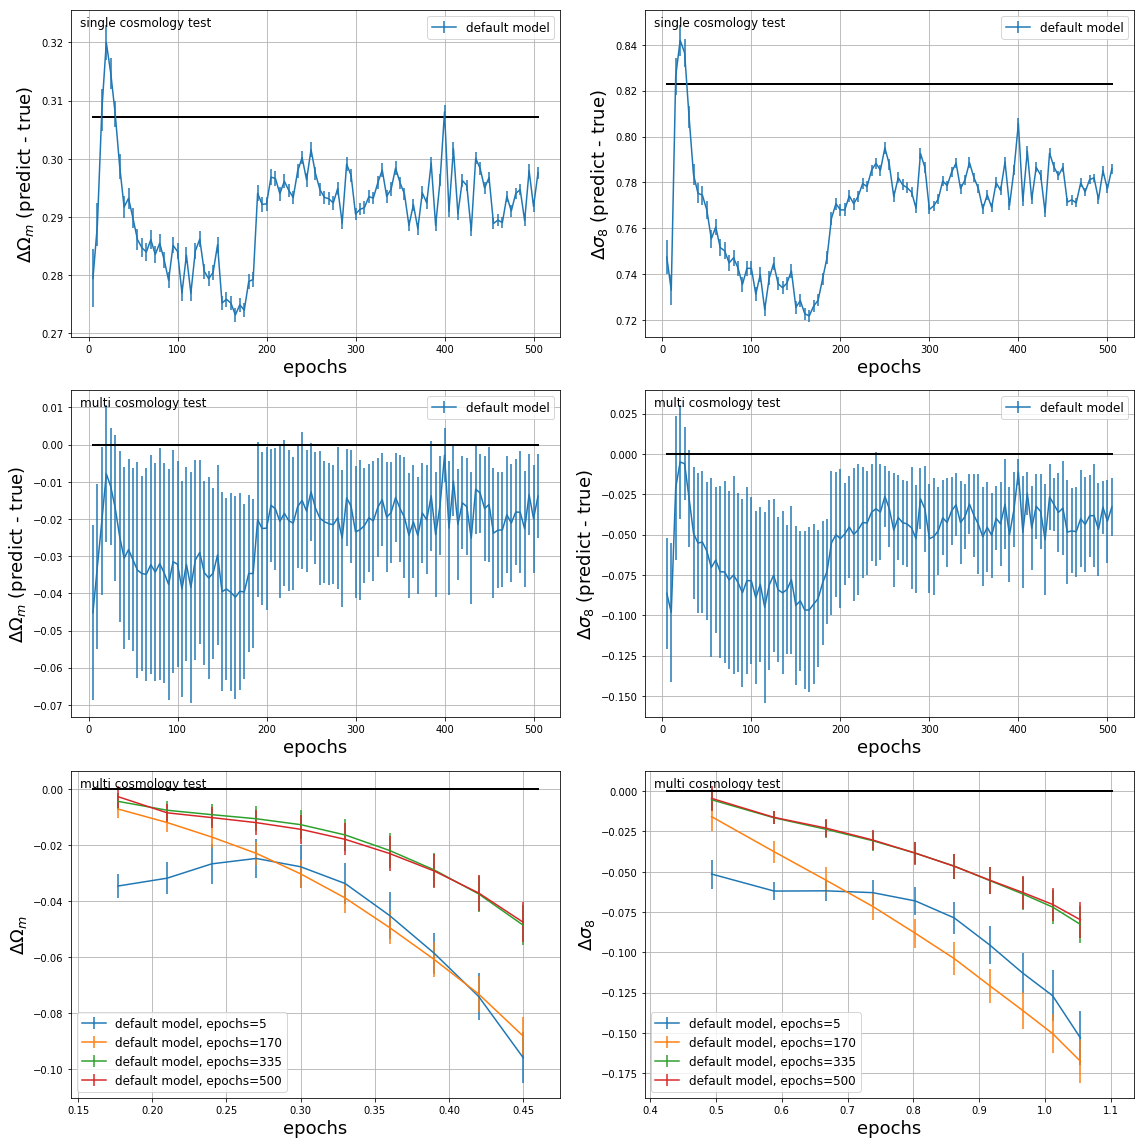

In [137]:
def filename_function(epochs):
    return 'epochs_test/'+str(epochs)+'.save.test_output'
fig = None
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default model')

##### sgd

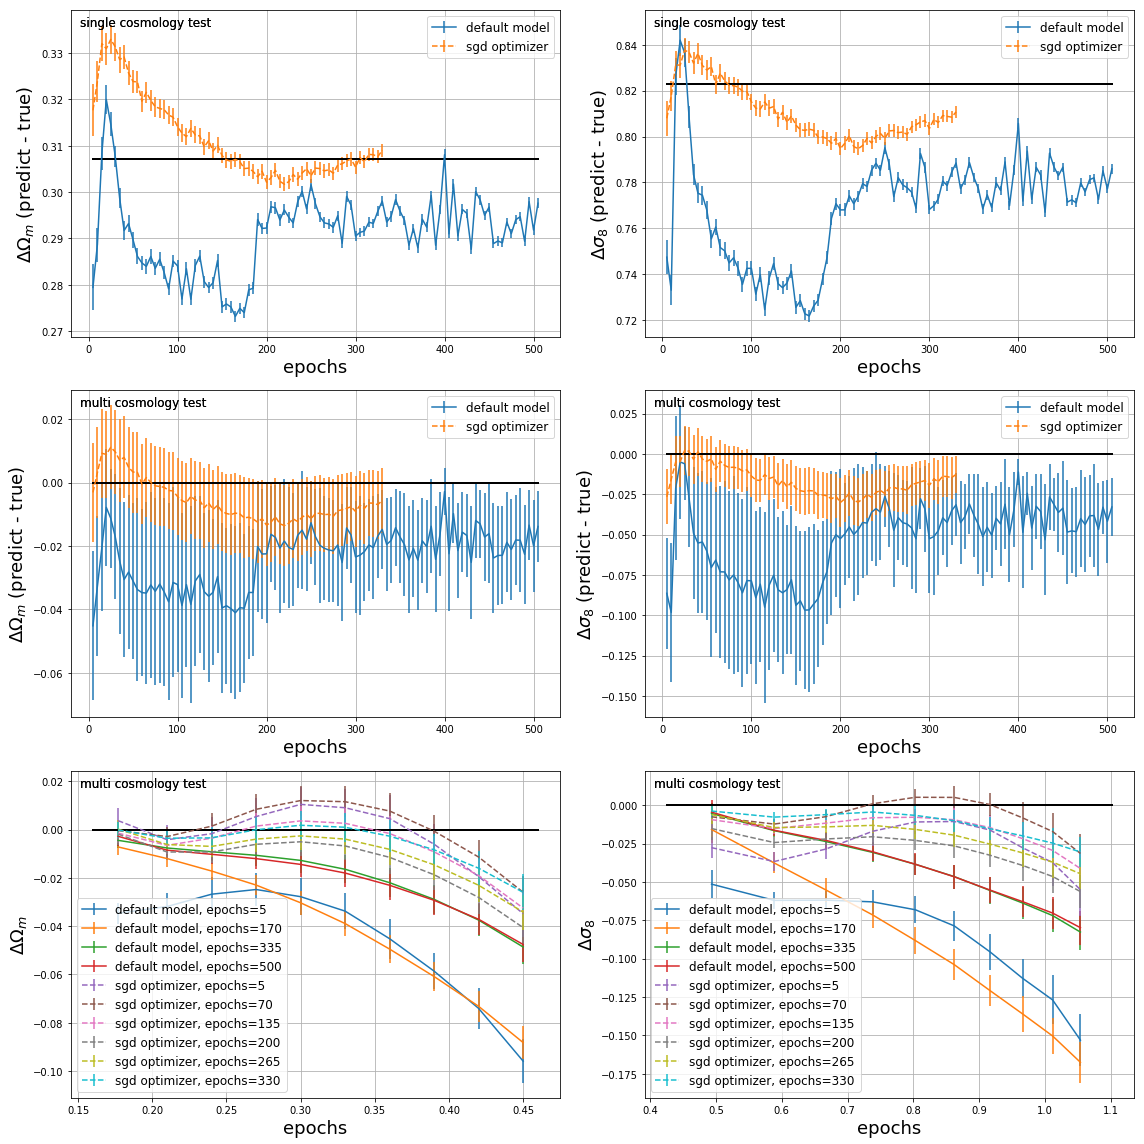

In [138]:
def filename_function(epochs):
    return 'sgd/'+str(epochs)+'.save.test_output'
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,335,5), var_name = 'epochs', single_plot_rat=5,
                  curve_name = 'sgd optimizer', fig=fig, axs=axs, ls='--')
fig.savefig('sgd.png', format='png')
fig

##### default, laptop

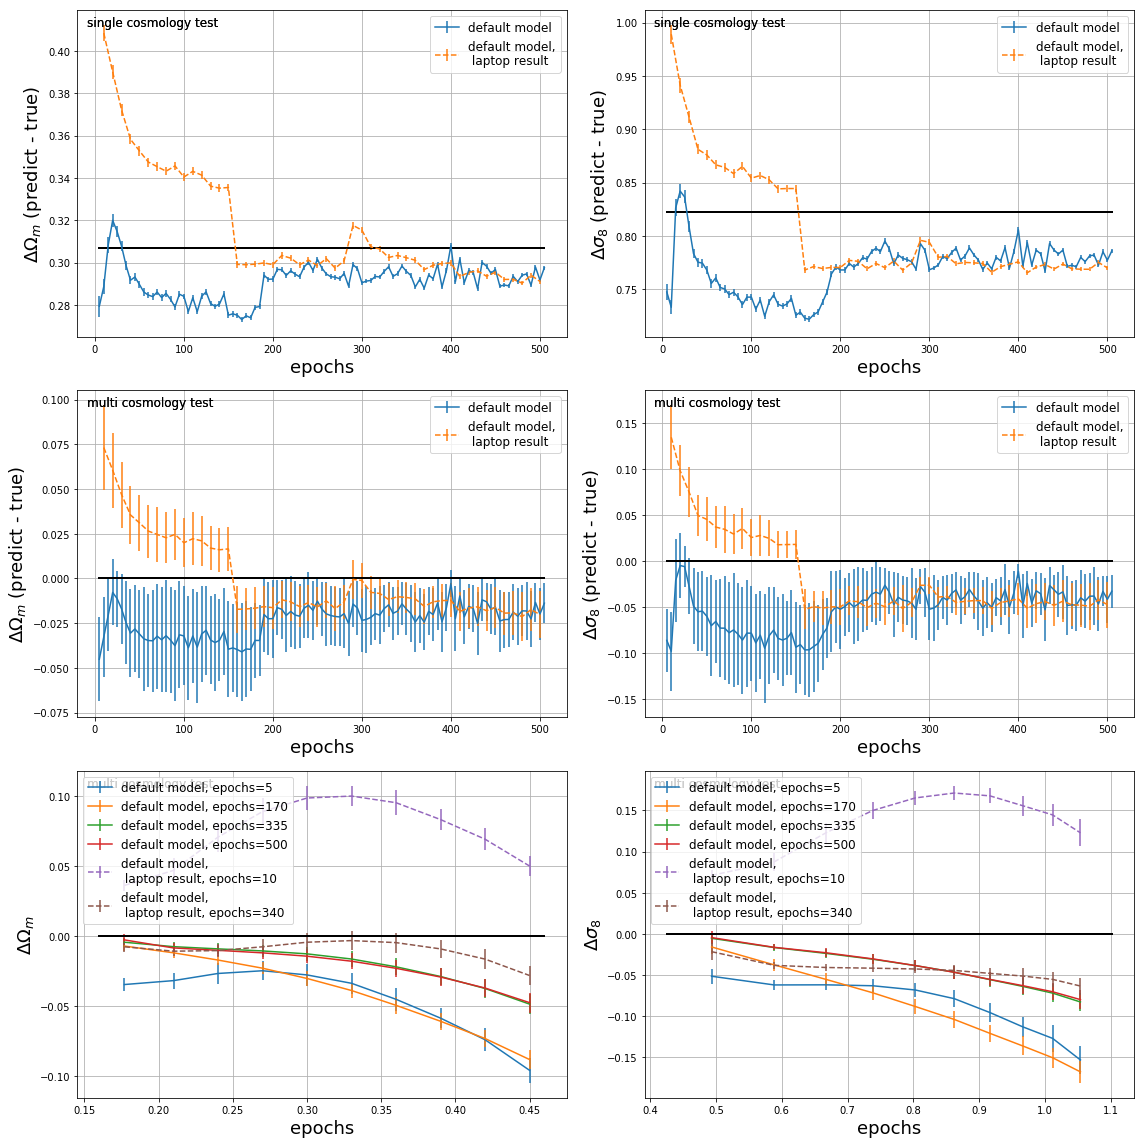

In [139]:
def filename_function(epochs):
    return 'epochs_test/'+str(epochs)+'.save.test_output'
fig = None
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default model')

def filename_function(epochs):
    return 'epochs_xiaodonglaptop/'+str(epochs)+'.save.test_output'
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default model,\n laptop result', fig=fig, axs=axs, ls='--')
fig.savefig('laptopresult.png', format='png')

##### max pooling

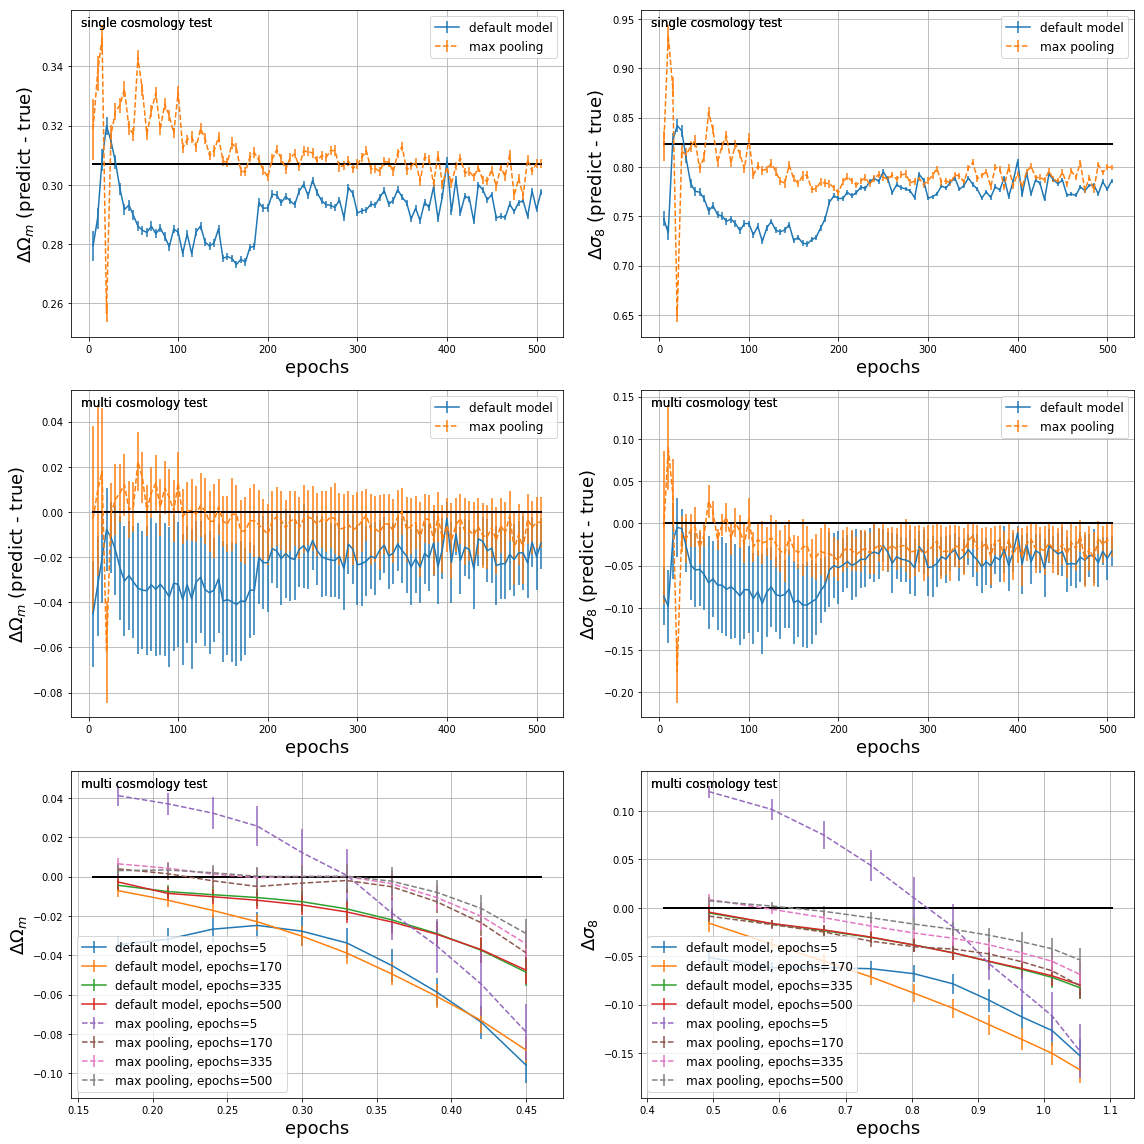

In [140]:
def filename_function(epochs):
    return 'epochs_test/'+str(epochs)+'.save.test_output'
fig = None
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default model')

def filename_function(epochs):
    return 'max_pooling/'+str(epochs)+'.save.test_output'
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'max pooling', fig=fig, axs=axs, ls='--')
fig.savefig('maxpool.png', format='png')

##### half filter

In [ ]:
def filename_function(epochs):
    return 'epochs_test/'+str(epochs)+'.save.test_output'
fig = None
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default model')

def filename_function(epochs):
    return 'half_filters//'+str(epochs)+'.save.test_output'
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'half filters', fig=fig, axs=axs, ls='--')
fig.savefig('halffilters.png', format='png')


##### half dense neurons

In [ ]:
def filename_function(epochs):
    return 'epochs_test/'+str(epochs)+'.save.test_output'
fig = None
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default model')

def filename_function(epochs):
    return 'half_dense/'+str(epochs)+'.save.test_output'
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'half dense', fig=fig, axs=axs, ls='--')
fig.savefig('halfdense.png', format='png')


##### pan models

In [ ]:
def filename_function(epochs):
    return 'epochs_test/'+str(epochs)+'.save.test_output'
fig = None
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default model')

def filename_function(epochs):
    return 'pan_Adam_lr=0.0005//'+str(epochs)+'.save.test_output'
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'pan Adam lr=0.0005', fig=fig, axs=axs, ls='--')
fig.savefig('panAdam.png', format='png')

##### test size 0

In [ ]:
def filename_function(epochs):
    return 'epochs_test/'+str(epochs)+'.save.test_output'
fig = None
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default model')

def filename_function(epochs):
    return './test_size_0.0/'+str(epochs)+'.save.test_output'
fig, axs, X1, rlts1, X2, rlts2 = \
    learningcurve(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'test_size_0', fig=fig, axs=axs, ls='--')
fig.savefig('testsize0.png', format='png')

## Grid test

##### single epoch test

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


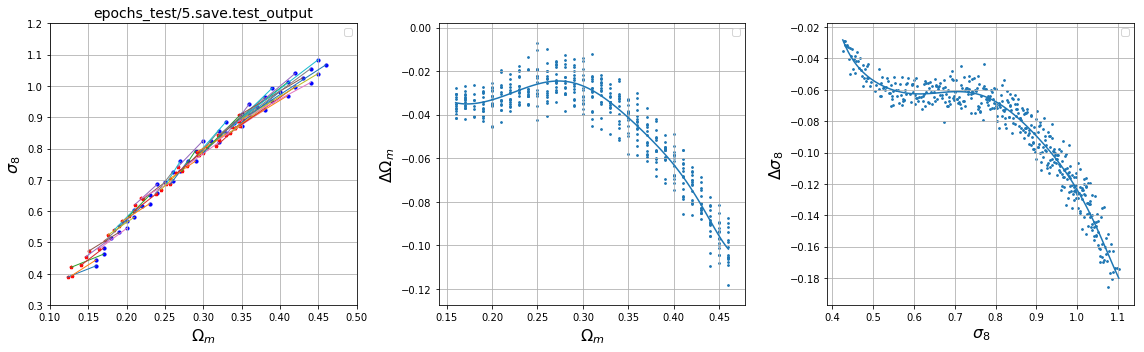

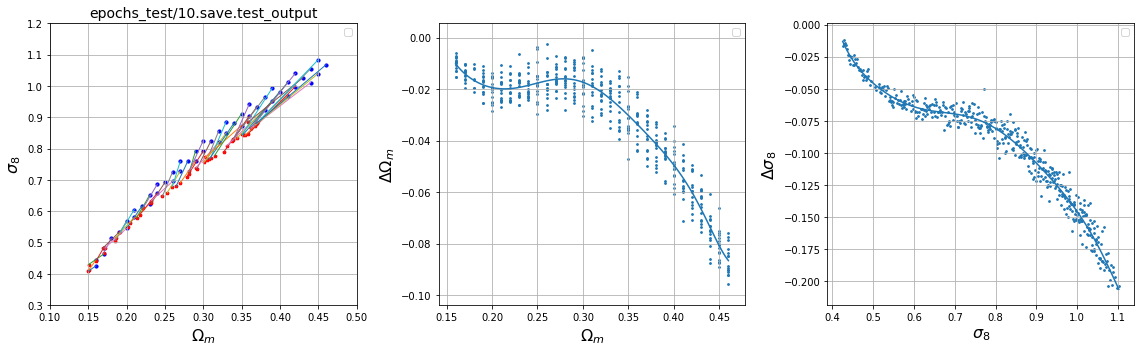

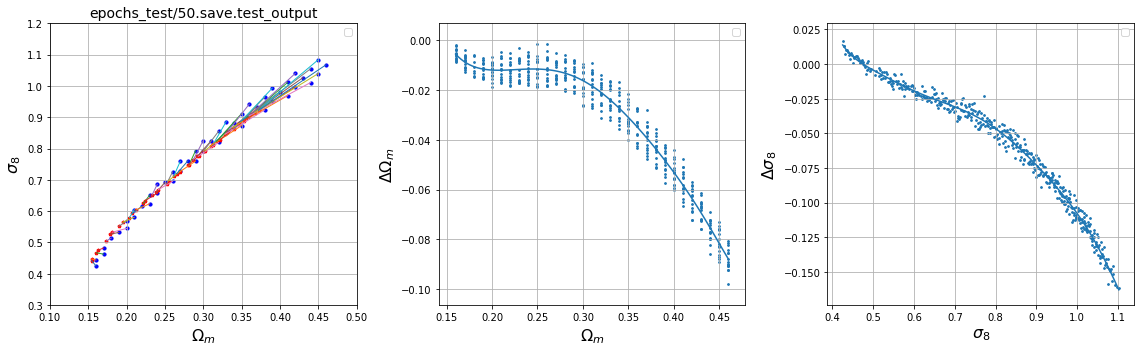

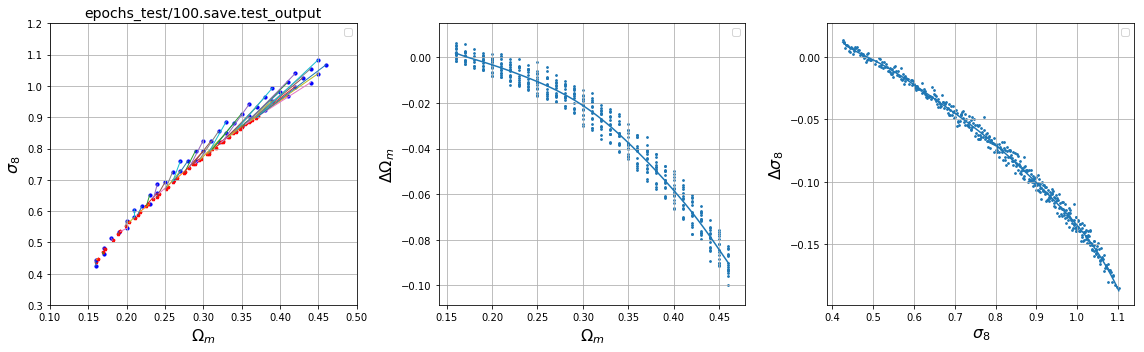

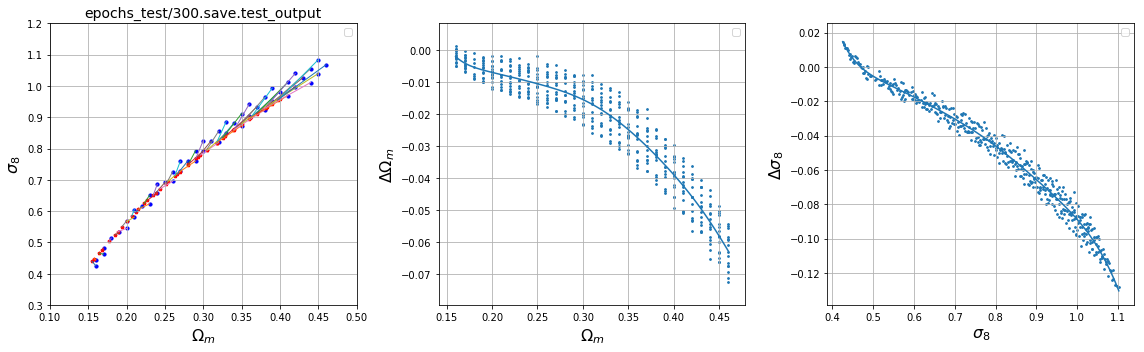

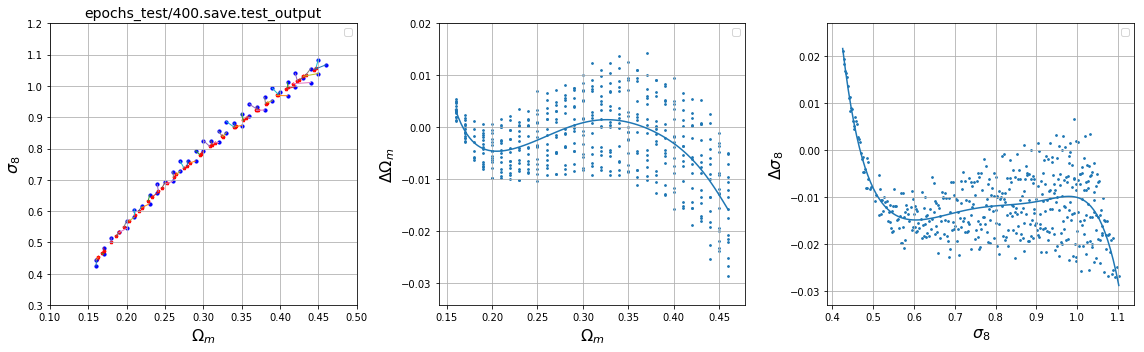

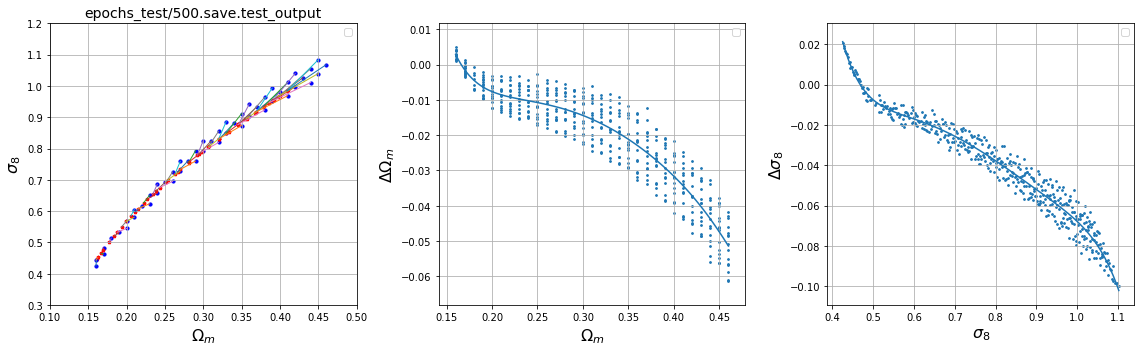

In [115]:
epochs_list = [5, 10, 50, 100, 300, 400, 500]
rlts = []
for epochs in epochs_list:
    file = 'epochs_test/'+str(epochs)+'.save.test_output'
    bigmd_dict, grid_dict = load_testfile(file)
    #oms, sig8s, doms, dsig8s = plot_grid_dict(grid_dict, title=file)
    rlts.append(plot_grid_dict(grid_dict, title=file))

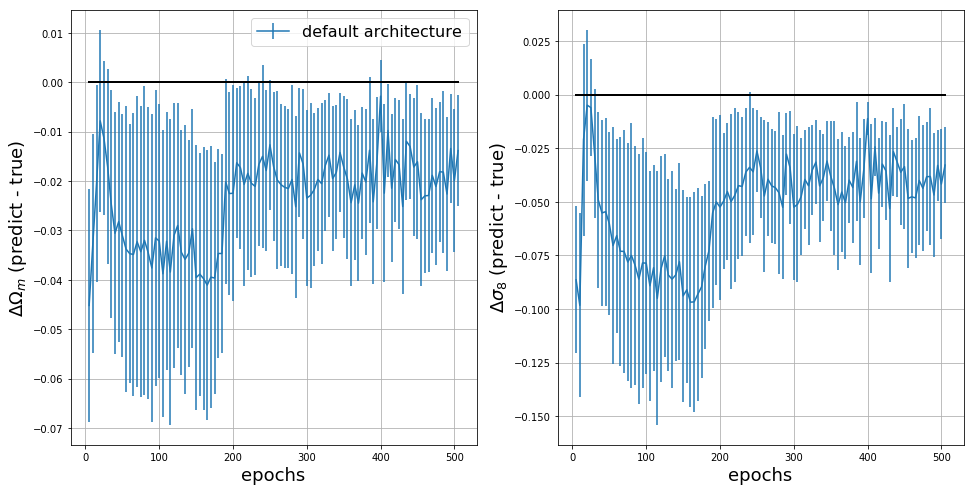

In [110]:
def filename_function(epochs):
    return 'epochs_test/'+str(epochs)+'.save.test_output'
fig = None
fig, axs, epochs_list, epochs_list_rlts = \
    learningcurve_grid(filename_function, range(5,510,5), var_name = 'epochs', 
                  curve_name = 'default architecture')